In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import visualkeras
import read_data_tensorflow as read_data
import threading
import tqdm.notebook as tqdm
%matplotlib inline

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)

#############################################
#load data, fashion MNIST
org_train_images, train_labels, test_images, test_labels = read_data.load_fashion_mnist_dataset()

#load data, MNIST
#org_train_images, train_labels, test_images, test_labels = read_data.load_mnist_dataset()

train_images = np.expand_dims(org_train_images, 3) #train x
train_images = train_images.astype(np.float32)
org_train_images = org_train_images.astype(np.float32)
test_images = np.expand_dims(test_images, 3)       #test x
test_images = test_images.astype(np.float32)

train_labels = train_labels.astype(np.float32)     #train y
test_labels = test_labels.astype(np.float32)       #test y

#normalize all data
train_images = train_images /255.0
test_images = test_images   /255.0


In [2]:
#use multiple 1 filter CNN layer to comprise a multi filter CNN layer

#ideas for reducing resolution by factor of 2
#1. use 4x4 filter and stride 2
#2. use 2x2 filter and stride 2
#3. use a flatten layer for computation (?)

#customized activation function
def bell_tanh_activation(x):
    #shapes like a bell
    #when x in 0 to 1, y approaches 1
    #and decreases on both sides and approaches -1
    #use 5+5x tanh
    x1 = 10-5*x
    x2 = 5*x
    return tf.minimum(tf.tanh(x1), tf.tanh(x2))
    
def gaussian_activation(x, tilt_level = 0.85): #last best -- 1.1
    x = tilt_level-tilt_level*x
    return 2*tf.exp(-(x**2)) - 1 #range -1 to 1


def gaussian_activation_01(x, tilt_level = 0.83):#0.85): #last best -- 1.1
    x = tilt_level-tilt_level*x
    return tf.exp(-(x**2)) #range 0 to 1


#sigmoid
#1/(1+e^-x)

#======================================================================
# Notes:
# proves that sigmoid is better, for unknown reason
# probably because the gradient is non-zero for all values of x
# In contrast, bell has gradient approaching 0 not only on two ends, but in middle, and hence is harder to train
#======================================================================



class extensible_CNN_layer_multi_module(tf.keras.Model):
    #growth model
    #input: nxnx1
    #output: 1*n
    #filter number can increase
    #last parameter:
    # kernel_size = (4,4), stride = 2, activation = 'gaussian_bell', padding = 'valid', optimizer = 'adam'
    #best: gaussian bell of 1 tilt level, with reg on weight and bias, and 3x3 filter with stride 1
    def __init__(self, kernel_size = (4,4), stride = 2, activation = 'gaussian_bell_01', padding = 'valid', optimizer = 'adam'): #best -- gaussian_bell, 4x4, stride 2
        super(extensible_CNN_layer_multi_module, self).__init__()
        self.filter_list = []
        self.bias_list = []
        self.kernel_size = kernel_size
        self.stride = stride
        
        self.activation = activation
        self.channels = 1
        self.threshold = 0.5
        if self.activation == "gaussian_bell":
            self.threshold = 0.4 #0.34 final -- 0.4 one layer
        if self.activation == "sigmoid":
            self.threshold = 0.8 #from 0.5 to 0.7, unstable
        if self.activation == "relu":
            self.threshold = 0.5
        if self.activation == "gaussian_bell_01":
            self.threshold = 0.5 #last 0.5    
        
        if (activation == 'bell_tanh'):
            self.activation = bell_tanh_activation
        if (activation == 'gaussian_bell'):
            self.activation = gaussian_activation
        if (activation == 'gaussian_bell_01'):
            self.activation = gaussian_activation_01
         

        
        
        self.padding = padding
        self.optimizer = optimizer
        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.legacy.Adam()
        else:
            print("\noptimizer not implemented\n")
            return
        
        self.sample_space = {}
        self.filter_list = [] 
        #initialized with 1 filter
    
    def patch_normalize(self, x):
        normalized_x = x
        luminance = x #to multiply x again after calculation
        #normalize each patch of image so that they can erase the affection of luminance
        #then the output from filters will be multiplied by coeff to recover the original luminance
        
        return normalized_x
    
    def call(self, input_x):
        #input
        feature_maps = []
        for filter_i in self.filter_list:
            feature_maps.append(filter_i(input_x))
        return tf.concat(feature_maps, axis = 3) #concatenate feature maps
    
    def add_filter(self, x, epochs = 10, refit = False, regularization = True, image_x = None):
        #use autoencoder to generate a new filter which accepts x
        #x: 3x3x1
        #check if x is 3x3x1
        
        if x.shape != (self.kernel_size[0], self.kernel_size[1], 1):
            print("x is not fit for filter size")
            return
        
        #check if x is equivalent to any existing filter's sample space
        #print(type(self.sample_space))
        for sample_i in self.sample_space.keys():
            #plt.imshow(self.sample_space[sample_i].reshape(self.kernel_size[0], self.kernel_size[1]), cmap = 'gray')
            #plt.show()
            #print(np.sum(abs(self.sample_space[sample_i] - x)), np.sum(self.sample_space[sample_i]), sample_i)
            if np.sum(abs(self.sample_space[sample_i] - x)) < 0.2:
                print("x is already in sample space")
                return
        
        x = x.reshape(1, self.kernel_size[0], self.kernel_size[1], 1)
        #initialize a new filter with decoder
        
        
        
        
        new_filter = tf.keras.layers.Conv2D(1, self.kernel_size, padding=self.padding, activation=self.activation,strides=self.stride)
        decoder = tf.keras.layers.Conv2DTranspose(1, self.kernel_size, padding=self.padding, activation=self.activation,strides=self.stride)
        
        #set weights of new filter to be the same as x
        print("new filter initialized, id = ", len(self.filter_list))
        
        #initialize new filter
        
        #get the 1 matrix of x
        #TODO: use a better way to get the 1 matrix of x
        #  by giving a suitable threshold -- example, 0.5
        zero_pixel_threshold = 0
        
        matrix_1 = (x > zero_pixel_threshold).astype(np.float64)
        
        
        #characterization = x/np.max(x)
        bias = np.array([-1]) #0
        if (np.max(x) > zero_pixel_threshold):
            #characterization =(x/np.max(x))
            #equals to the 1 matrix of x
            #random_filter = np.random.rand(3,3,1)/5
            random_filter = np.random.rand(self.kernel_size[0], self.kernel_size[1], 1)/5
            #avoid a random_filter value on pixel <= 0
            #multiply by dot product of matrix_1 and random_filter
            random_filter = np.multiply(matrix_1, random_filter)
            
            #devide by 5 so that the maximum output is 0.2*16 - 1 = 2.2
            #characterization = characterization/5  #/np.average(characterization)
            
            #or divide by the size of the filter, setting bias to 0, so the output is 1
            bias = np.array([-1])
            characterization = (matrix_1 + x)/np.sum(matrix_1) - random_filter
            matrix_n1 = matrix_1 - 1 #if is 0, then -1
            matrix_n1 *= (np.sum(characterization))
            characterization = characterization + matrix_n1
            
            #characterization = characterization/np.sum(matrix_1) - random_filter
            
            #characterization -= random_filter
            
            
        else:
            bias = np.array([1])
            characterization = x - 2*(bias)    #/(np.max(x)+0.01)
            #print(characterization)
            
        #print("characterization = ", characterization, "matrix_1 = ", matrix_1)
        #characterization = np.asarray(characterization - 1 + matrix_1).reshape(1,self.kernel_size[0],self.kernel_size[1],1).astype(np.float64)
        characterization = np.asarray(characterization).reshape(1,self.kernel_size[0],self.kernel_size[1],1).astype(np.float64)
        
        #normalize
        #characterization = characterization/np.max(characterization)
        new_filter.build(input_shape = (1,self.kernel_size[0],self.kernel_size[1],1))
        new_filter.set_weights([characterization.reshape(self.kernel_size[0],self.kernel_size[1],1,1), bias])
        decoder.build(input_shape = (1,1,1,1))
        decoder.set_weights([characterization.reshape(self.kernel_size[0],self.kernel_size[1],1,1), bias])
        #the weight of this filter is characterized by x

        #train the new filter
        #new filter must reject all other x in the sample space
        self.filter_list.append(new_filter)
        
        def calc_reg(weight, bias):
            reg = 0
            #reg = tf.reduce_sum((tf.square(weight)))# + tf.reduce_sum(tf.square(bias))
            #reg = tf.reduce_sum((weight))
            #reg += tf.reduce_sum(bias)
            #reg += tf.reduce_sum(tf.square(bias))
            #reg = tf.square(reg)
            
            return reg
            
        #==============================================
        #sub-functions that can be reused in this function
        def call_autoencoder(x):
            y = new_filter(x)
            y = decoder(y)
            #because decoder has activation, so y is in range [0,1]
            #hence magnify y by max in x
            y = y * np.max(x)
            return y
        
        
        def fit_autoencoder(x):
            '''
            autoencoder = tf.keras.Model(new_filter.input, call_autoencoder(new_filter.input))
            autoencoder.compile(optimizer=self.optimizer, loss=self.loss)
            autoencoder.fit(x, x, epochs=epochs, verbose=0)
            '''

            #use gradient descent to train the new filter
            #consider the sample space and the autoencoder 
            
            loss = 0
            with tf.GradientTape(persistent=True) as tape:
                y = call_autoencoder(x)
                #use sum of square error as loss function
                loss = tf.reduce_sum(tf.square(y - x))
                #a regularization by calculating sum of weights
                if regularization:
                    loss += calc_reg(new_filter.weights[0], new_filter.weights[1])
                    #loss += tf.reduce_sum((new_filter.weights[0]))# + new_filter.weights[1]))
            grad_filter = tape.gradient(loss, new_filter.trainable_variables)
            grad_decoder = tape.gradient(loss, decoder.trainable_variables)
            self.optimizer.apply_gradients(zip(grad_filter, new_filter.trainable_variables))
            self.optimizer.apply_gradients(zip(grad_decoder, decoder.trainable_variables))
            #clear tape
            tf.keras.backend.clear_session()
            return loss
        
        def fit_filter(negative_samples):
            loss = 0
            with tf.GradientTape(persistent=True) as tape:
                y = new_filter(negative_samples)
                #expect y to be close to -1
                loss = tf.reduce_sum(tf.square(y) - -1)
                if regularization:
                    #make weights close to a sum of 1
                    loss += calc_reg(new_filter.weights[0], new_filter.weights[1])
                    #loss += tf.reduce_sum((new_filter.weights[0]))# + new_filter.weights[1]))
                #the square makes loss reduce faster, so more tolerant to negative samples
            grad_filter = tape.gradient(loss, new_filter.trainable_variables)
            self.optimizer.apply_gradients(zip(grad_filter, new_filter.trainable_variables))
            #clear tape
            tf.keras.backend.clear_session()
            return loss
        
        def combined_fit(target, negative_samples):
            loss = 0
            with tf.GradientTape(persistent=True) as tape:
                y = call_autoencoder(target)
                #use sum of square error as loss function
                loss = tf.reduce_sum(tf.square(y - target))
                #expect y to be close to 0
                z = new_filter(negative_samples)
                target_z = -1#-1
                #target_z = z - self.threshold
                loss += tf.reduce_sum(tf.square(z - target_z))# (0 - (1-self.threshold)))) #far from threshold
                #loss += tf.reduce_sum(tf.square(new_filter(negative_samples))) #targetting for 0
                loss += (tf.reduce_sum(tf.square(new_filter(target) - 1))) #targetting for 1

                #the above calculations can be improved
                if regularization:
                    loss += calc_reg(new_filter.weights[0], new_filter.weights[1])
                    #loss += tf.reduce_sum((new_filter.weights[0]))# + new_filter.weights[1]))
            grad_filter = tape.gradient(loss, new_filter.trainable_variables)
            grad_decoder = tape.gradient(loss, decoder.trainable_variables)
            self.optimizer.apply_gradients(zip(grad_filter, new_filter.trainable_variables))
            #last best not update decoder
            self.optimizer.apply_gradients(zip(grad_decoder, decoder.trainable_variables))
            #clear tape
            tf.keras.backend.clear_session()
            return loss
        #==============================================
        
        #
        progress_bar = tf.keras.utils.Progbar(epochs)
        
        #fit the new filter
        '''
        print("\nfitting the new filter")
        for epoch in (range(epochs)):
            
            loss = 0
            #fit the filter
            for i in range(len(self.filter_list) - 1):
                loss += fit_filter(self.sample_space[i])
            #fit the autoencoder
            loss += fit_autoencoder(x)
            progress_bar.update(epoch, values=[("loss", loss)])
        '''
            
        print("\ncombined training")
        for epoch in (range(epochs)):
            loss = 0
            for i in range(len(self.filter_list) - 1):
                loss = combined_fit(x, self.sample_space[i])
            progress_bar.update(epoch, values=[("loss", loss)])
        
        
        self.sample_space[len(self.filter_list) - 1] = x.reshape(1, self.kernel_size[0], self.kernel_size[1], 1) #add to sample space
        #plt.imshow(self.sample_space[len(self.filter_list) - 1][0,:,:,0])
        #plt.show()
        
        self.filter_list[len(self.filter_list) - 1] = new_filter #replace the filter
        
        
        if image_x is not None:
            print("\nUpdating the sample space")
            #get the feature map for different filters
            for filter_i in range(max(len(self.filter_list) - 5,0), len(self.filter_list)):
                feature_map = self.filter_list[filter_i](image_x)
                #get one of the max value's location
                max_loc_fm = np.unravel_index(np.argmax(feature_map, axis=None), feature_map.shape)#[0]
                #print(max_loc_fm, feature_map.shape, image_x.shape)
                #map back to the image_x
                org_x = int((max_loc_fm[1]/feature_map.shape[1]) * (image_x.shape[1] - self.kernel_size[0]))
                org_y = int((max_loc_fm[2]/feature_map.shape[1]) * (image_x.shape[2] - self.kernel_size[1]))
                #find the patch from image_x
                self.sample_space[filter_i] = image_x[:, (org_x):(org_x + self.kernel_size[0]), (org_y):(org_y + self.kernel_size[1]), :].reshape(1, self.kernel_size[0], self.kernel_size[1], self.channels)
                #print(org_x, org_y, max_loc_fm, "!!!")
                #plt.imshow(self.sample_space[filter_i].reshape(self.kernel_size[0], self.kernel_size[1]))
                #plt.show()
        if refit:
            #fit all the filters
            self.refit_all(epochs = epochs)
        
        return new_filter
    
    
    def refit_all(self, epochs = 100, image_x = None):
        #refit all the filters with their own sample (1) and other filters' samples (-1)
        #update the sample space
                
        def refit_filter(idx, epochs):
            print("\nrefitting filter ", idx)
            progress_bar = tf.keras.utils.Progbar(epochs)
            for epoch in range(epochs):
                filter_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
                loss = 0
                with tf.GradientTape(persistent=True) as tape:
                    
                    #fit the filter
                    for i in range(len(self.filter_list)):
                        if (i == idx):
                            loss += tf.reduce_sum(tf.square(self.filter_list[i](self.sample_space[i]) - 1))
                        else:
                            loss += tf.reduce_sum(tf.square(self.filter_list[i](self.sample_space[i]) - -1))
                grad_filter = tape.gradient(loss, self.filter_list[idx].trainable_variables)
                filter_optimizer.apply_gradients(zip(grad_filter, self.filter_list[idx].trainable_variables))
                progress_bar.update(epoch, values=[("loss", loss)])
            #clear tape
            
            tf.keras.backend.clear_session()
            
        
        for i in range(max(int(len(self.filter_list)/2)-1,0), len(self.filter_list)):
            refit_filter(i, epochs)
    
    #TODO: following functions are needed potentially when the learning covers more images
    def collapse_check(self, example_img):
        #check if the filters are overlapping
        return
    
    def collapse_overlapping(self, example_img):
        #collapse the overlapping filters
        return
    
    
    
    def get_index_map(self, x):
        feature_maps = self.call(x)
        return np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    
            
#new_filter = customized_CNN_kernel(4, 2, 'relu')

def show_indedx_act_map(model, img):
    threshold = model.threshold
    
    #show the index map and activation map
    
    feature_maps = model.call(img.reshape(1, img.shape[0], img.shape[1], 1))
    index_map = np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    #print("!")
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(index_map, cmap = "gist_ncar")
    ax.set_title("index map")
    
    #print("index map shape", index_map.shape)
    activated_points = np.zeros(np.shape(index_map))
    mapping = np.max(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    activated_points[mapping > 0.5] = 1
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(mapping, cmap = "gray")
    print("min and max", np.min(mapping), np.max(mapping))
    #plt.set_title("activated points")
    
    fig.show()
    plt.show()
    
def show_all_index_maps(model, data_0_9):
    #show the heatmap of 10 images
    #show 20 images
    figure = plt.figure(figsize=(20, 20))


    #show the heatmap of 10 images and 10 original images
    #5 images one row

    for i in range(len(images_x_0_9)):
        feature_maps = tf.convert_to_tensor(my_model.call(images_x_0_9[i]).numpy().astype('float64'))
        plt.subplot((len(images_x_0_9) * 2) // 5, 5, i+1 + (i // 5) * 5)
        plt.imshow(images_x_0_9[i].reshape(28,28), cmap='gray')
        plt.title("label "+ str(i))
        plt.subplot((len(images_x_0_9) * 2) // 5, 5, i+6 + (i // 5) * 5)
        index_map = np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
        plt.imshow(index_map, cmap='gist_ncar')

    plt.show()


            

In [3]:
  
    

def generate_filter(image_x, model, threshold = 0.4, last_selected = [-1, -1]):

    filter_size = model.kernel_size
    stride = model.stride
    feature_map_size = (np.shape(image_x)[1] - filter_size[0])//stride + 1
    #print("feature map size", feature_map_size)
    if len(model.filter_list) == 0:
        #add a filter for null input
        null_input = np.zeros((1,filter_size[0],filter_size[1],1))
        
        new_filter = model.add_filter(null_input[0], epochs = 100)
        if new_filter is None:
            return None
        #show
        #based on filter size, reshape
        plt.imshow(new_filter.get_weights()[0].reshape(filter_size[0],filter_size[1]), cmap='gray')
        plt.show()
        print("filter null weight",new_filter.get_weights()[0].reshape(filter_size[0],filter_size[1]),"\nbias", new_filter.get_weights()[1])
        #show the result on the image
        plt.imshow(new_filter(image_x)[0].numpy().reshape(feature_map_size, feature_map_size), cmap='gray')
        plt.show()
        
        

    #call the model and find the points that are inactivated
    feature_maps = model.call(image_x)
    #find the max of feature maps
    #sum_feature_maps = np.sum(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    max_feature_maps = np.max(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    #find the points that are inactivated
    inactive_points = np.where(max_feature_maps <= threshold)
    #print("inactive points", inactive_points)
    #randomly select a point
    #set seed
    if (len(inactive_points[0]) == 0):
        return model
    
    point = np.random.randint(0, len(inactive_points[0]))
    
    selected = point%5 #select the edge point
    #selected = -1
    #selected = point 
    
    x = inactive_points[0][selected]
    y = inactive_points[1][selected]

    print("selected point", x, y)
    if (x == last_selected[0] and y == last_selected[1]):
        selected = -1
        x = inactive_points[0][selected]
        y = inactive_points[1][selected]
        print("Selected point is the same as last time, remaining", len(inactive_points[0]), "points")
        print("re-selected point", x, y)
    #print remaining and total
    
    print("remaining", len(inactive_points[0]), "points", "total", (feature_map_size)**2)
    #if (len(inactive_points[0]) < (feature_map_size**2) * 0.1):
    #    return model
    last_selected[0] = x
    last_selected[1] = y
    #set the location to middle pixel

    #get the patch according to filter size and stride
    patch = image_x[0][x*stride:x*stride+filter_size[0], y*stride:y*stride+filter_size[1], 0].reshape(1,filter_size[0],filter_size[1],1).astype(np.float64)
    #patch = image_x[0][x:x+3,y:y+3,:].reshape(1,3,3,1).astype(np.float64)

    
    #add a filter for the patch
    new_filter = model.add_filter(patch[0], epochs = 100)#, image_x = image_x)
    if new_filter is None:
        return None
    #get feature map size according to filter size and stride
    feature_map_size = (np.shape(image_x)[1] - filter_size[0])//stride + 1
    feature_map_new_filter = new_filter(image_x)[0].numpy().reshape(feature_map_size,feature_map_size)
    print("new filter generated\n=============================================\n")
    plt.imshow(new_filter.get_weights()[0].reshape(filter_size[0], filter_size[1]), cmap='gray')
    plt.show()
    plt.imshow(feature_map_new_filter, cmap='gray')
    plt.show()
    print("feature map min and max", np.min(feature_map_new_filter), np.max(feature_map_new_filter))
    print("\nfilter weight",new_filter.get_weights()[0].reshape(filter_size[0],filter_size[1]),"\nbias", new_filter.get_weights()[1])
    print("threshold", threshold)
    return model
    

In [4]:
np.random.seed(1)
def generate_model(img_x, model = None):
    image_x = img_x.reshape(1, img_x.shape[0], img_x.shape[1], 1)
    last_selected = [-1, -1]

    
    my_model = model
    if model == None:
        my_model = extensible_CNN_layer_multi_module()
    
    filter_size = my_model.kernel_size
    stride = my_model.stride
    
    threshold = my_model.threshold
    

    print("activation and threshold")
    print(my_model.activation, threshold)
    for i in range(20): #generate a series of filters
        generate_filter(image_x, my_model, threshold = threshold)

    print(my_model.activation, len(my_model.filter_list))
    return my_model
    

def generate_model_on_images(images, model):
    #initialize by generating 2 filters on the first image
    if model == None:
        model = extensible_CNN_layer_multi_module()
    
    model = generate_filter(images[0].reshape(1, images[0].shape[0], images[0].shape[1], 1), model, threshold = model.threshold)
    
    #loop through the images, generate filters
    for i in range(len(images)):
        model = generate_filter(images[i].reshape(1, images[i].shape[0], images[i].shape[1], 1), model, threshold = model.threshold)
    print(model.activation, len(model.filter_list))
    return model
        


In [5]:
#get the images 0 - 9
images_x_0_9 = []
images_y_0_9 = []
n_shot = 1
for label_idx in range(10):
    for i in range(n_shot):
        image_label_i = np.where(train_labels == label_idx)[0]
        image_x_i = train_images[image_label_i][i].reshape(1,28,28,1).astype('float64')
        image_y_i = label_idx
        one_hot_y_i = tf.one_hot(image_y_i, 10).numpy().reshape(1,10)
        #train_one_shot(image_x_i, one_hot_y_i)
        images_x_0_9.append(image_x_i)
        images_y_0_9.append(one_hot_y_i)
    
print(len(images_x_0_9))



10


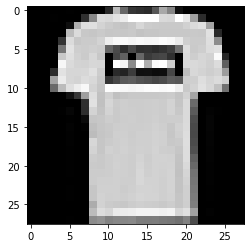

activation and threshold
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 0.5
new filter initialized, id =  0

combined training
  0/100 [..............................] - ETA: 0s - loss: 0.0000e+00

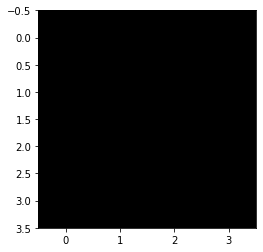

filter null weight [[-2. -2. -2. -2.]
 [-2. -2. -2. -2.]
 [-2. -2. -2. -2.]
 [-2. -2. -2. -2.]] 
bias [1.]


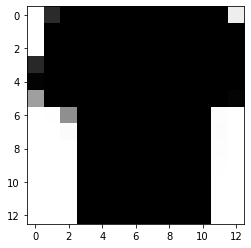

selected point 0 3
remaining 129 points total 169
new filter initialized, id =  1

combined training
 98/100 [============================>.] - ETA: 0s - loss: 6.5662- ETA: 0s - loss: 6.790 - ETA: 0s - loss: new filter generated



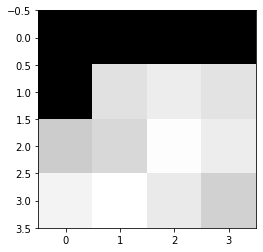

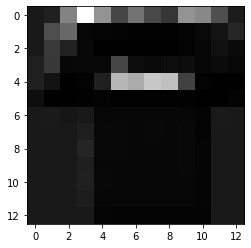

feature map min and max 0.00032309498 0.8841864

filter weight [[-0.4942703  -0.4942703  -0.4942703  -0.4942703 ]
 [-0.4942703   0.16190878  0.19465914  0.16788219]
 [ 0.09939378  0.13363872  0.24095921  0.19442622]
 [ 0.2131408   0.24914233  0.18746197  0.11297836]] 
bias [-0.8735716]
threshold 0.5
selected point 0 5
remaining 122 points total 169
new filter initialized, id =  2

combined training
 98/100 [============================>.] - ETA: 0s - loss: 6.6388- ETA: 0s - loss: 7.220 - ETA: 0s - loss: 7.145 - ETA: 0s - loss: - ETA: 0s - loss: 6.569 - ETA: 0s - loss: 6.5013new filter generated



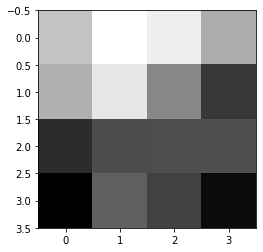

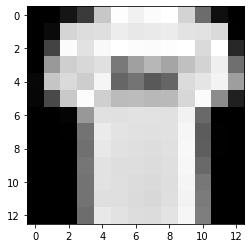

feature map min and max 0.05251078 1.0

filter weight [[ 0.345186    0.46487743  0.43250075  0.29996172]
 [ 0.30616513  0.41499302  0.22470307  0.06323274]
 [ 0.04327556  0.10514457  0.10660559  0.11017335]
 [-0.04829267  0.14479932  0.08413751 -0.02659975]] 
bias [-1.0574418]
threshold 0.5
selected point 0 11
remaining 24 points total 169
new filter initialized, id =  3

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.6230- ETA: 0s - loss: 1.635new filter generated



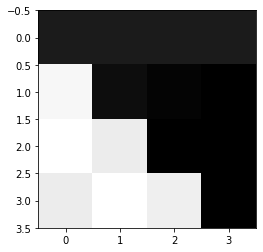

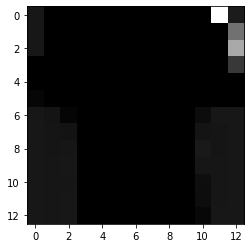

feature map min and max 2.2501873e-35 0.9977217

filter weight [[-1.0719824  -1.0719824  -1.0719824  -1.0719824 ]
 [ 0.51480955 -1.1706897  -1.2385687  -1.2696347 ]
 [ 0.57937264  0.43838984 -1.2710427  -1.2675986 ]
 [ 0.43805614  0.57739204  0.45829615 -1.2645392 ]] 
bias [-0.8659976]
threshold 0.5
selected point 0 1
remaining 22 points total 169
new filter initialized, id =  4

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2634- ETA: 0s - loss: new filter generated



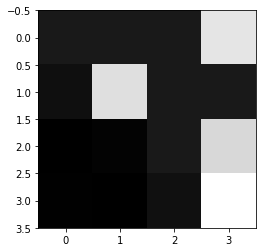

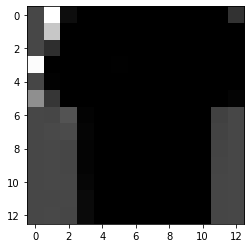

feature map min and max 3.6975516e-22 0.8383918

filter weight [[-0.8279748  -0.8279748  -0.8279748   0.9735396 ]
 [-0.9189821   0.9201433  -0.8298443  -0.8309758 ]
 [-1.0566691  -1.0286201  -0.83104384  0.8561936 ]
 [-1.0466797  -1.0571693  -0.91478574  1.2077098 ]] 
bias [-0.4506602]
threshold 0.5
selected point 0 10
remaining 19 points total 169
new filter initialized, id =  5

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.8906- ETA: 2s - l - ETA: 1s new filter generated



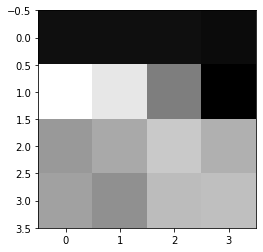

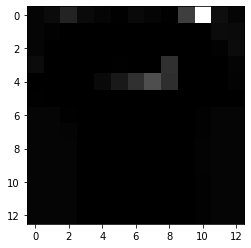

feature map min and max 9.892187e-13 0.9549479

filter weight [[-0.95650595 -0.95652777 -0.956523   -0.9846776 ]
 [ 0.75464875  0.5831483  -0.16513367 -1.0647296 ]
 [ 0.02531917  0.13999258  0.3661681   0.1904293 ]
 [ 0.0813452  -0.03882146  0.2784723   0.29789847]] 
bias [-1.3780787]
threshold 0.5
selected point 0 2
remaining 18 points total 169
new filter initialized, id =  6

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2727new filter generated



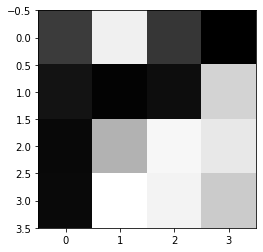

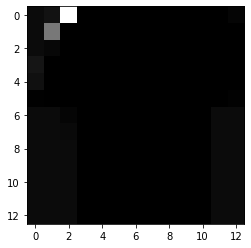

feature map min and max 7.831958e-22 0.9732319

filter weight [[-0.90470445  0.5127872  -0.9370843  -1.3656193 ]
 [-1.2173623  -1.3354647  -1.2612913   0.28160626]
 [-1.300883    0.02547761  0.5671194   0.4506227 ]
 [-1.2924187   0.6308624   0.5336879   0.22385572]] 
bias [-1.1387345]
threshold 0.5
selected point 2 1
remaining 17 points total 169
new filter initialized, id =  7

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.4495new filter generated



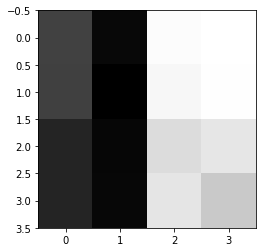

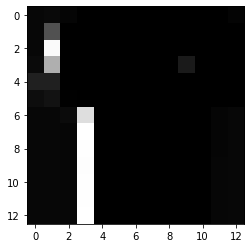

feature map min and max 1.3553661e-26 0.99971944

filter weight [[-0.8808706  -1.2981919   0.49417248  0.51628655]
 [-0.88954824 -1.3616667   0.45378786  0.5036455 ]
 [-1.0859106  -1.3111825   0.2555739   0.32771796]
 [-1.0865641  -1.3096989   0.32382348  0.1170446 ]] 
bias [-1.2746527]
threshold 0.5
selected point 5 12
remaining 10 points total 169
new filter initialized, id =  8

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0667new filter generated



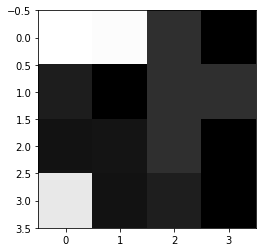

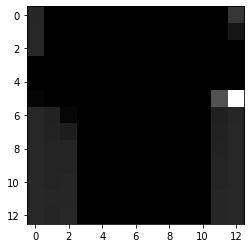

feature map min and max 0.0 0.9476031

filter weight [[ 1.1724114  1.1371526 -1.1490659 -1.6785185]
 [-1.3477516 -1.6785185 -1.1490659 -1.1490659]
 [-1.4754201 -1.4548572 -1.1490659 -1.6817689]
 [ 0.9109201 -1.4756973 -1.3392816 -1.682006 ]] 
bias [-0.6743478]
threshold 0.5
selected point 5 1
remaining 9 points total 169
new filter initialized, id =  9

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1405new filter generated



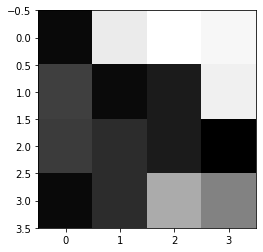

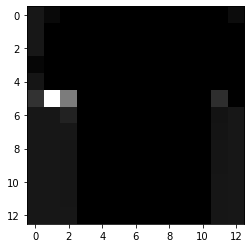

feature map min and max 0.0 0.9636388

filter weight [[-1.4389031   0.6779747   0.86569244  0.78952307]
 [-0.92840487 -1.4284874  -1.2651727   0.7250064 ]
 [-0.97445583 -1.0963529  -1.2728271  -1.5255691 ]
 [-1.4391009  -1.1020528   0.07251911 -0.3028306 ]] 
bias [-0.88047755]
threshold 0.5
selected point 4 0
remaining 8 points total 169
new filter initialized, id =  10

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0654- ETA: 2s - los - ETA: 1s - loss: new filter generated



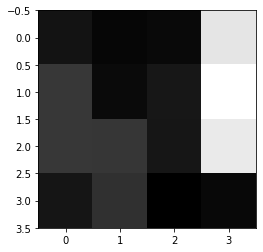

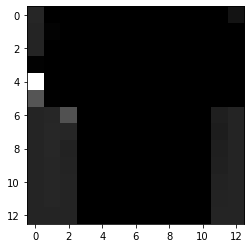

feature map min and max 0.0 0.9520474

filter weight [[-1.6155307 -1.7783146 -1.7404209  0.9560817]
 [-1.1750005 -1.7214262 -1.5676323  1.2838386]
 [-1.1751136 -1.1822137 -1.5784552  1.0219815]
 [-1.5936509 -1.2451059 -1.855148  -1.7470863]] 
bias [-0.68630856]
threshold 0.5
selected point 1 12
remaining 7 points total 169
new filter initialized, id =  11

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0426  ETA: 10s - loss: 1. - ETA: 9s -  - ETA: 7s - loss: 1.06 - ETA: 6s - loss: 1.064 - ETA: 6s - loss:  - ETA: 5s - loss: 1.0 - ETA: 4s - loss: 1.0 - ETA: 4s - loss: 1. - ETA: 3s - loss: 1.05 - ETA: 3s - loss: 1 - ETA: 2s - lnew filter generated



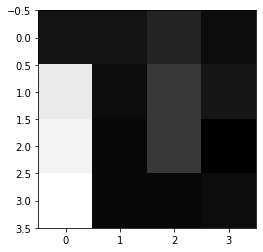

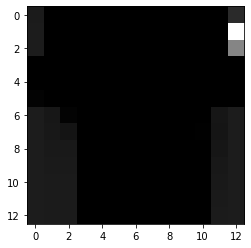

feature map min and max 0.0 0.96711963

filter weight [[-1.5809582 -1.5816796 -1.3894945 -1.6552014]
 [ 0.8311706 -1.6499132 -1.1536727 -1.5420568]
 [ 0.9275438 -1.7014066 -1.1536727 -1.7951292]
 [ 1.066458  -1.7014141 -1.7013289 -1.65362  ]] 
bias [-0.79998684]
threshold 0.5
selected point 7 10
remaining 6 points total 169
new filter initialized, id =  12

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.5653- ETA: 6s - lo - ETAnew filter generated



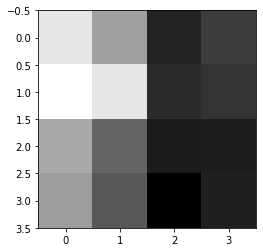

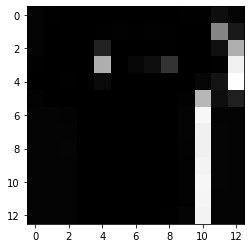

feature map min and max 3.020203e-11 0.99686545

filter weight [[ 0.71629167  0.28492618 -0.48980874 -0.32730484]
 [ 0.87522775  0.7192415  -0.42775285 -0.3883591 ]
 [ 0.34205443 -0.08514228 -0.5364746  -0.52619624]
 [ 0.26612493 -0.16163431 -0.70736504 -0.5118628 ]] 
bias [-1.3968205]
threshold 0.5
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 13


In [6]:
img_0 = images_x_0_9[0].reshape(28,28)
plt.imshow(img_0.reshape(28,28), cmap='gray')
plt.show()

my_model = generate_model(img_0)

min and max 0.5064587 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


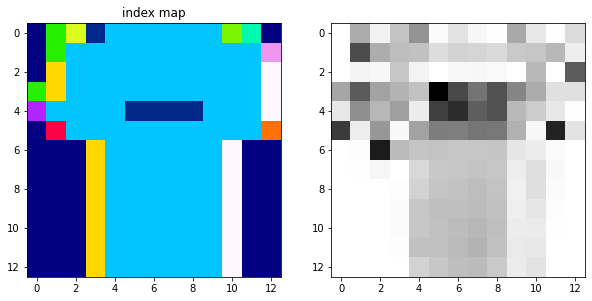

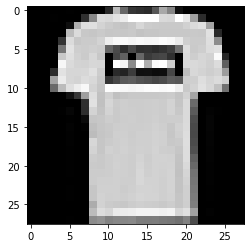

In [7]:
show_indedx_act_map(my_model, img_0)

plt.imshow(img_0, cmap='gray')
plt.show()

min and max 0.31137323 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


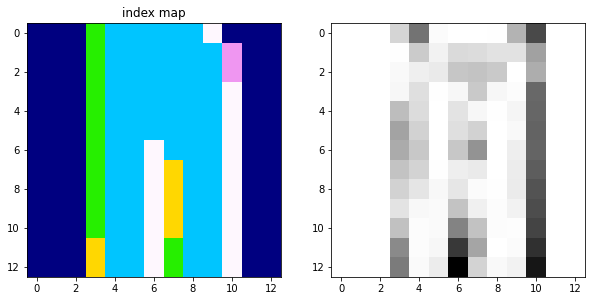

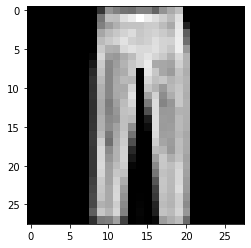

In [8]:
#for img 1
img_1 = images_x_0_9[1].reshape(28,28)
show_indedx_act_map(my_model, img_1)
plt.imshow(img_1.reshape(28,28), cmap='gray')
plt.show()

activation and threshold
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 0.5
selected point 11 6
remaining 5 points total 169
new filter initialized, id =  13

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.3814new filter generated



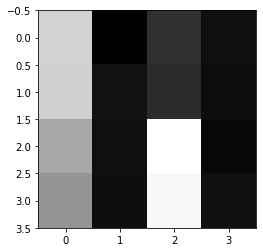

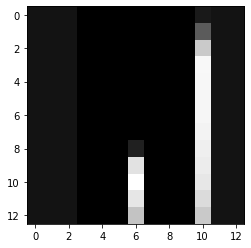

feature map min and max 0.0 0.97313726

filter weight [[ 0.94206375 -1.7903093  -1.1576195  -1.5905639 ]
 [ 0.9173972  -1.5481567  -1.2250296  -1.610054  ]
 [ 0.3940305  -1.5874665   1.5253508  -1.683195  ]
 [ 0.14706211 -1.5979892   1.4151219  -1.5788983 ]] 
bias [-0.9511115]
threshold 0.5
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 14


In [9]:
my_model = generate_model(img_1, model = my_model)

min and max 0.51028496 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


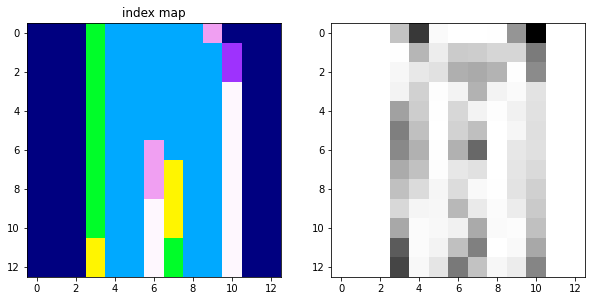

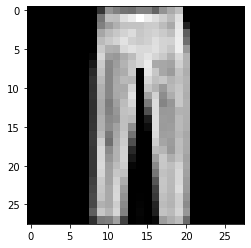

In [10]:
show_indedx_act_map(my_model, img_1)
plt.imshow(img_1.reshape(28,28), cmap='gray')
plt.show()

min and max 0.29031253 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


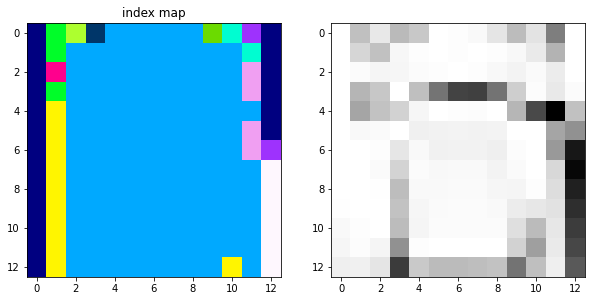

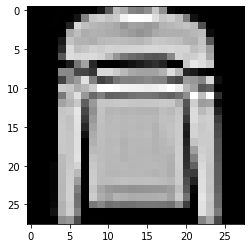

In [11]:
#for img 2
img_2 = images_x_0_9[2].reshape(28,28)
show_indedx_act_map(my_model, img_2)
plt.imshow(img_2.reshape(28,28), cmap='gray')
plt.show()

activation and threshold
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 0.5
selected point 3 7
remaining 11 points total 169
new filter initialized, id =  14

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.3481new filter generated



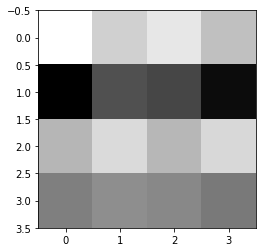

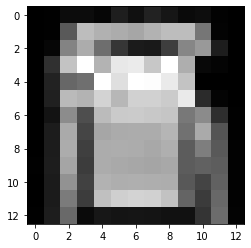

feature map min and max 0.004128867 0.9991166

filter weight [[ 0.87940633  0.5645001   0.712789    0.4580982 ]
 [-0.8309094  -0.29254344 -0.35809773 -0.7461424 ]
 [ 0.38824946  0.6257188   0.39635482  0.6162111 ]
 [ 0.01800111  0.11809359  0.07893527 -0.01816296]] 
bias [-1.6555011]
threshold 0.5
selected point 8 12
remaining 9 points total 169
new filter initialized, id =  15

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1703new filter generated



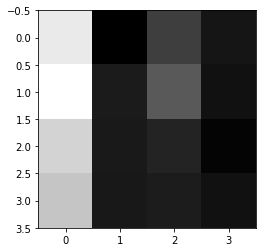

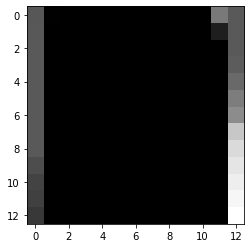

feature map min and max 0.0 0.8142606

filter weight [[ 0.58657473 -1.9251107  -1.2589282  -1.6921161 ]
 [ 0.81181675 -1.6263007  -0.96691537 -1.7375954 ]
 [ 0.3429924  -1.6526746  -1.5417135  -1.8742646 ]
 [ 0.18675844 -1.6602886  -1.6214187  -1.7408412 ]] 
bias [-0.34721953]
threshold 0.5
selected point 4 11
remaining 4 points total 169
new filter initialized, id =  16

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2009new filter generated



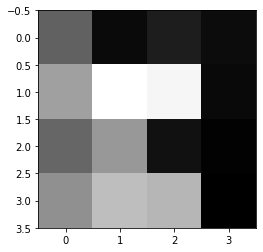

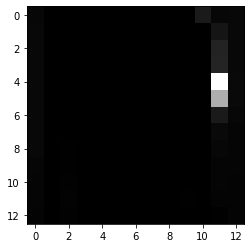

feature map min and max 1.7917617e-21 0.9452931

filter weight [[-0.42148817 -1.3446418  -1.1400169  -1.3265661 ]
 [ 0.26037744  1.2761797   1.1732095  -1.3554463 ]
 [-0.36120716  0.17317592 -1.2753104  -1.4312495 ]
 [ 0.08818587  0.57199496  0.49461505 -1.4600725 ]] 
bias [-1.25267]
threshold 0.5
selected point 4 10
remaining 3 points total 169
new filter initialized, id =  17

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.5249new filter generated



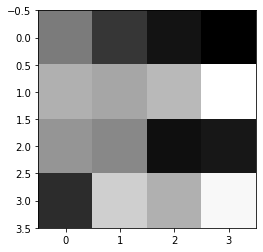

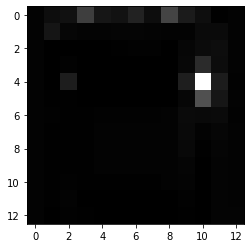

feature map min and max 2.8082382e-06 0.84576225

filter weight [[-0.0052123  -0.4090202  -0.61986923 -0.73271483]
 [ 0.30916646  0.25103435  0.36238334  0.7808314 ]
 [ 0.14858927  0.07475451 -0.64288205 -0.59623677]
 [-0.46334353  0.4920132   0.31179985  0.7378174 ]] 
bias [-1.5360537]
threshold 0.5
selected point 6 12
remaining 2 points total 169
new filter initialized, id =  18

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2892new filter generated



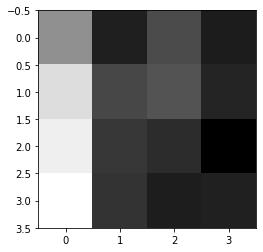

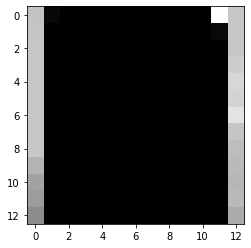

feature map min and max 0.0 0.66628635

filter weight [[-0.6739868  -1.6575131  -1.2742686  -1.6864983 ]
 [ 0.00472193 -1.3098663  -1.2063409  -1.603914  ]
 [ 0.16473943 -1.447926   -1.5366457  -1.9367892 ]
 [ 0.30744275 -1.4846157  -1.6798242  -1.6404079 ]] 
bias [0.02514655]
threshold 0.5
selected point 12 3
remaining 1 points total 169
new filter initialized, id =  19

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1591new filter generated



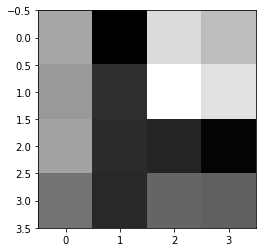

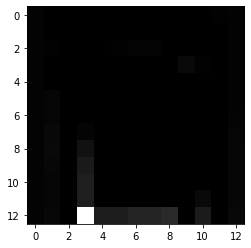

feature map min and max 8.01628e-11 0.9588009

filter weight [[ 0.28592673 -1.3218331   0.8007383   0.5050777 ]
 [ 0.15822084 -0.8620123   1.1484706   0.85668916]
 [ 0.27005225 -0.9067491  -0.9621336  -1.2830073 ]
 [-0.20520473 -0.9245949  -0.33990744 -0.38617325]] 
bias [-1.5027853]
threshold 0.5
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 20
min and max 0.5909115 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


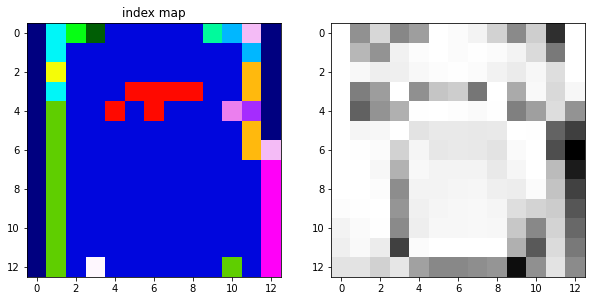

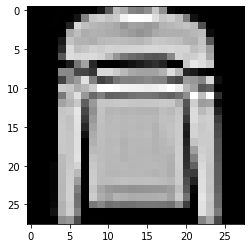

In [12]:
#train on img 2
new_model = generate_model(img_2, model = my_model)

show_indedx_act_map(new_model, img_2)
plt.imshow(img_2.reshape(28,28), cmap='gray')
plt.show()

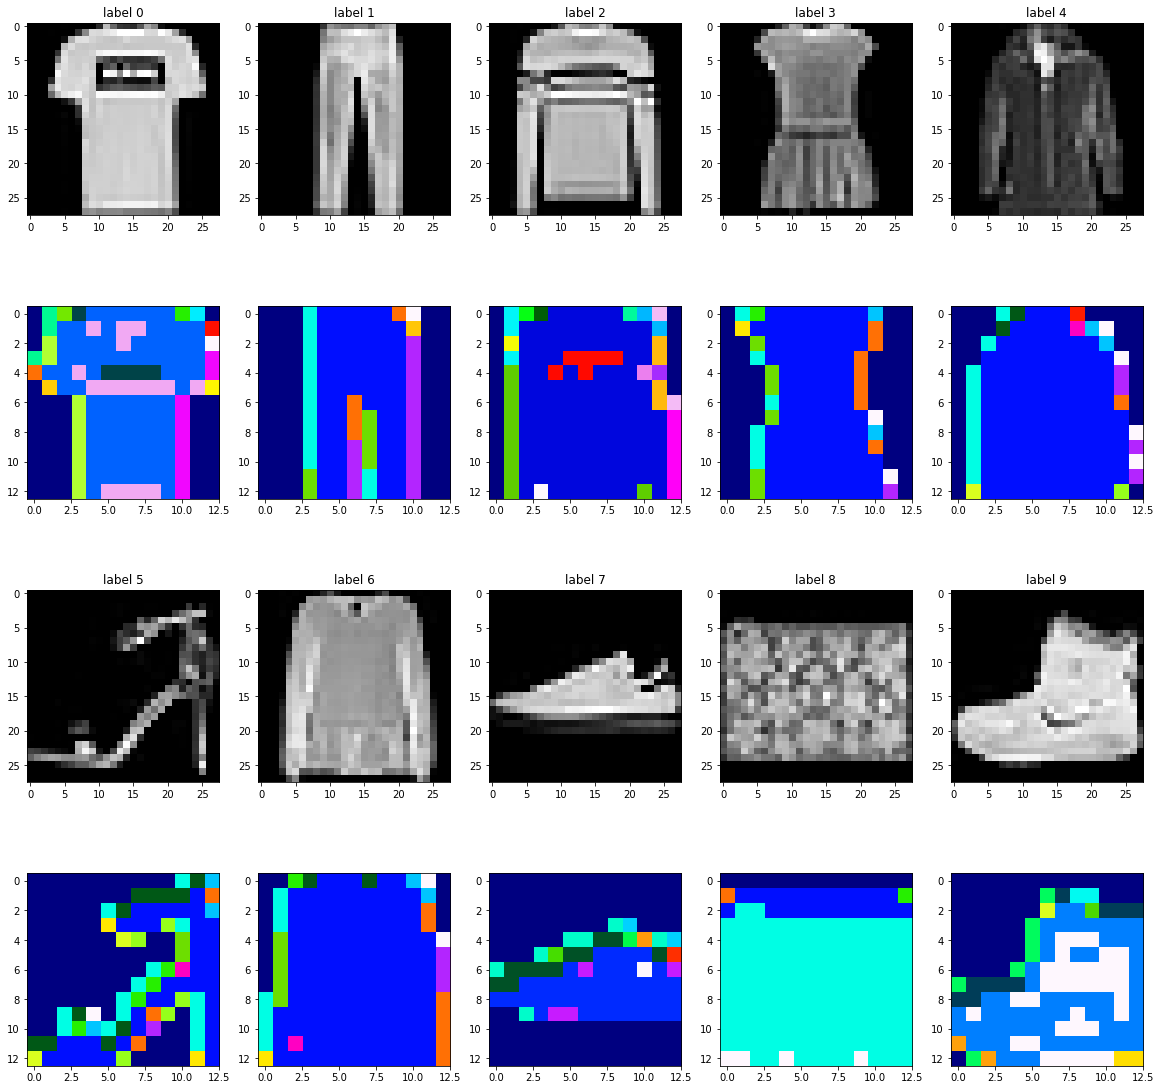

activation and threshold
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 0.5
selected point 5 9
remaining 16 points total 169
new filter initialized, id =  20

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1704new filter generated



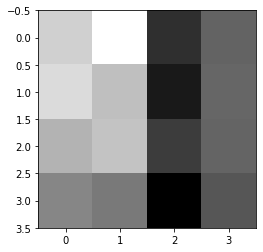

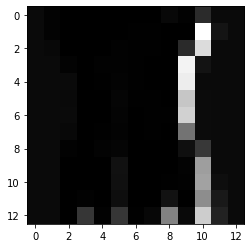

feature map min and max 1.4968866e-07 0.9939363

filter weight [[ 0.70779693  1.1802013  -0.8808988  -0.36382878]
 [ 0.8209742   0.54316396 -1.1031502  -0.34332627]
 [ 0.42997953  0.5857926  -0.7574932  -0.35359517]
 [-0.01908594 -0.15300252 -1.3529383  -0.4926431 ]] 
bias [-1.1509334]
threshold 0.5
selected point 8 3
remaining 10 points total 169
new filter initialized, id =  21

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0747new filter generated



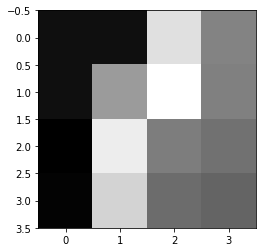

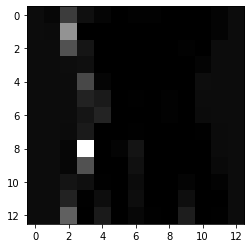

feature map min and max 1.3244181e-06 0.9112169

filter weight [[-1.0749004  -1.0817486   0.92849225  0.03026078]
 [-1.0757309   0.26829705  1.2299373   0.00210475]
 [-1.2280035   1.0562116  -0.02031727 -0.13534503]
 [-1.1940311   0.80223656 -0.18486655 -0.25876775]] 
bias [-1.1316671]
threshold 0.5
selected point 2 2
remaining 9 points total 169
new filter initialized, id =  22

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1293new filter generated



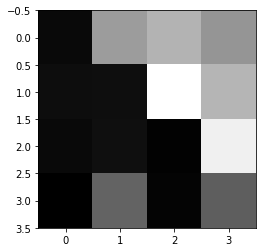

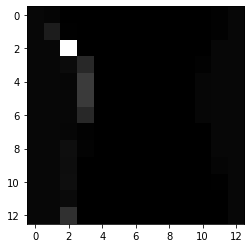

feature map min and max 1.6459108e-13 0.94298553

filter weight [[-1.0725502   0.2218823   0.43240285  0.15376751]
 [-1.0317198  -1.0239507   1.0919502   0.43882054]
 [-1.0731795  -1.0157917  -1.127578    0.9516772 ]
 [-1.1536713  -0.28096786 -1.1154052  -0.3236077 ]] 
bias [-1.2933364]
threshold 0.5
selected point 8 5
remaining 8 points total 169
new filter initialized, id =  23

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.7352new filter generated



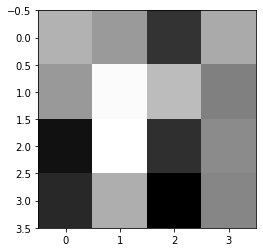

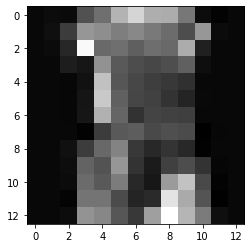

feature map min and max 0.024552079 0.9858238

filter weight [[ 0.42289093  0.2706609  -0.39995363  0.37222955]
 [ 0.2589943   0.90144587  0.4878346   0.09694529]
 [-0.6235004   0.92911726 -0.4305144   0.1701549 ]
 [-0.47391024  0.39573413 -0.738008    0.13985132]] 
bias [-1.054377]
threshold 0.5
selected point 8 10
remaining 7 points total 169
new filter initialized, id =  24

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1683new filter generated



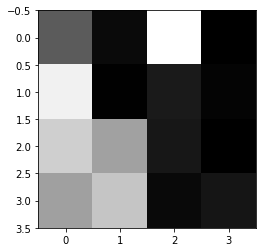

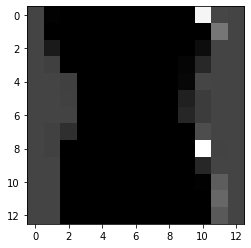

feature map min and max 4.1043267e-28 0.66864157

filter weight [[-0.7043798  -1.6016098   1.1020895  -1.7064072 ]
 [ 0.94391876 -1.6952684  -1.4194653  -1.6679832 ]
 [ 0.56832194  0.06338589 -1.4516412  -1.7157327 ]
 [ 0.04857567  0.46333104 -1.6124979  -1.4782449 ]] 
bias [-0.5835148]
threshold 0.5
selected point 11 2
remaining 6 points total 169
new filter initialized, id =  25

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0404new filter generated



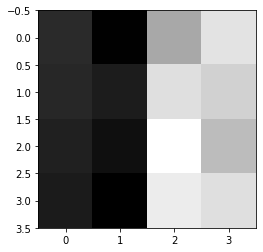

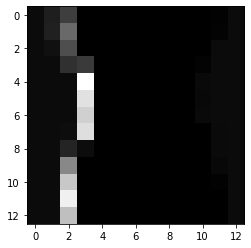

feature map min and max 2.1116723e-19 0.99426824

filter weight [[-1.2789984  -1.6975653   0.01538244  0.63518935]
 [-1.3133013  -1.4249487   0.58846056  0.43665642]
 [-1.3826579  -1.5531609   0.92047155  0.22358853]
 [-1.4372771  -1.7170458   0.7230019   0.5847402 ]] 
bias [-1.13061]
threshold 0.5
selected point 7 9
remaining 2 points total 169
new filter initialized, id =  26

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0630new filter generated



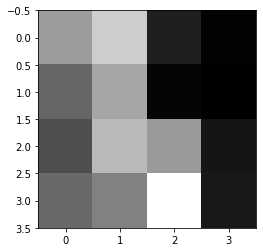

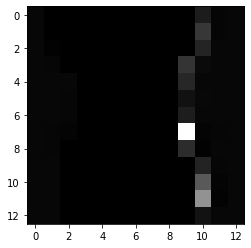

feature map min and max 1.7893058e-14 0.89991426

filter weight [[ 0.462804    1.1079425  -1.1698496  -1.5259479 ]
 [-0.2385545   0.59883845 -1.4981792  -1.5760086 ]
 [-0.5541203   0.84582996  0.4275192  -1.3000985 ]
 [-0.20559688  0.11517663  1.7627116  -1.2604101 ]] 
bias [-1.316678]
threshold 0.5
selected point 8 6
remaining 1 points total 169
new filter initialized, id =  27

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.6288new filter generated



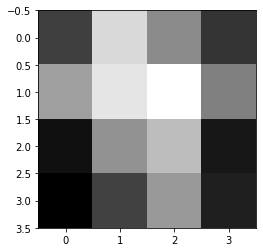

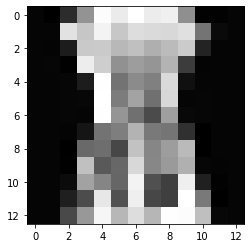

feature map min and max 0.005491161 0.9963946

filter weight [[-0.24676228  1.0047445   0.37035012 -0.3274615 ]
 [ 0.5297336   1.1021159   1.3136928   0.28457648]
 [-0.6269371   0.42738387  0.7778744  -0.56429744]
 [-0.75806767 -0.22321683  0.48163703 -0.50020725]] 
bias [-1.2737821]
threshold 0.5
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 28
min and max 0.52142745 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


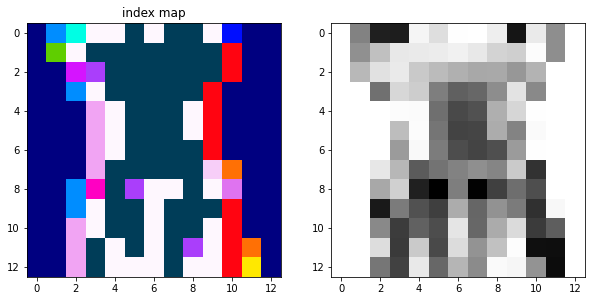

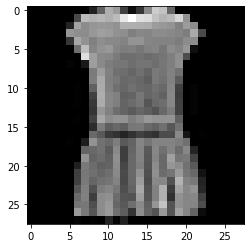

In [13]:
show_all_index_maps(new_model, images_x_0_9)
img_3 = images_x_0_9[3].reshape(28,28)
new_model = generate_model(img_3, model = new_model)
show_indedx_act_map(new_model, img_3)
plt.imshow(img_3.reshape(28,28), cmap='gray')
plt.show()



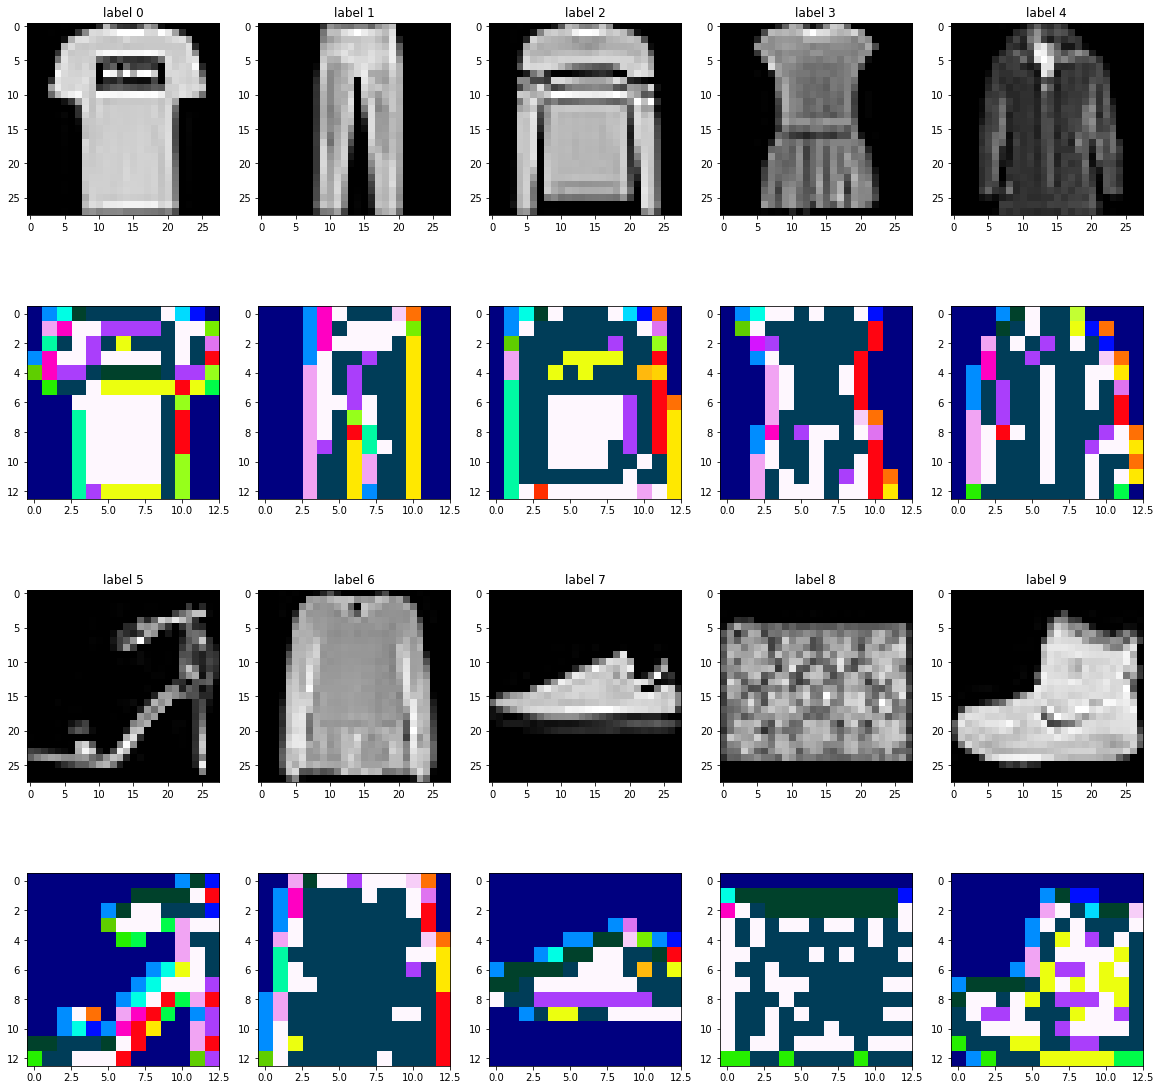

activation and threshold
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 0.5
selected point 0 7
remaining 112 points total 169
new filter initialized, id =  28

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.3889new filter generated



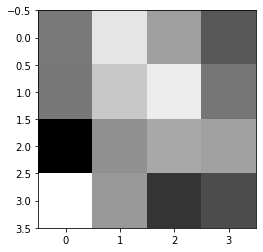

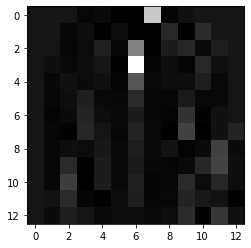

feature map min and max 0.0004287595 0.99583656

filter weight [[-0.31529737  1.0643674   0.15968005 -0.76503456]
 [-0.33842152  0.69300735  1.1696162  -0.36270753]
 [-1.8817827  -0.02559624  0.27310565  0.18737856]
 [ 1.4014454   0.069374   -1.1963768  -0.8971491 ]] 
bias [-0.88808715]
threshold 0.5
selected point 0 8
remaining 111 points total 169
new filter initialized, id =  29

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1638new filter generated



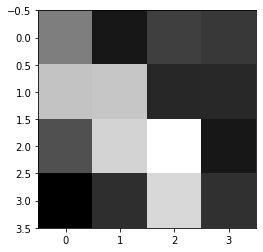

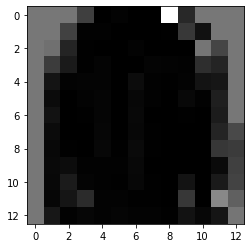

feature map min and max 2.5535467e-18 0.8377768

filter weight [[-0.13627563 -1.3969889  -0.905918   -0.98052925]
 [ 0.72816914  0.7510649  -1.2003876  -1.1829728 ]
 [-0.7041827   0.93490124  1.4654007  -1.4060975 ]
 [-1.6908528  -1.1158766   0.97415733 -1.0803728 ]] 
bias [-0.16590288]
threshold 0.5
selected point 0 4
remaining 110 points total 169
new filter initialized, id =  30

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.3373new filter generated



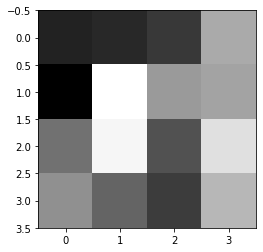

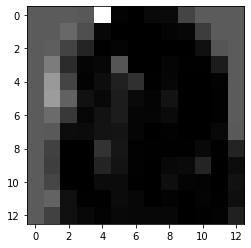

feature map min and max 2.0391015e-11 0.70852274

filter weight [[-1.454536   -1.3751805  -1.1717588   0.24393834]
 [-1.8819779   1.3014978   0.0427916   0.16061401]
 [-0.47481066  1.1859331  -0.8628849   0.9138991 ]
 [-0.0822591  -0.6322607  -1.1206653   0.40544656]] 
bias [-0.4111548]
threshold 0.5
selected point 0 3
remaining 109 points total 169
new filter initialized, id =  31

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1523new filter generated



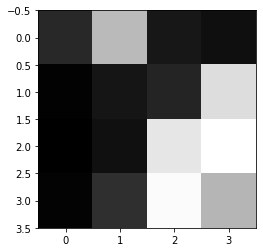

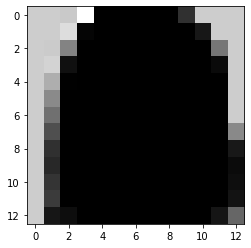

feature map min and max 0.0 0.7559572

filter weight [[-1.5176953  -0.17937277 -1.6693693  -1.7492285 ]
 [-1.8605705  -1.6866419  -1.5444459   0.13785785]
 [-1.8871938  -1.7320478   0.22008164  0.4553153 ]
 [-1.8563455  -1.4558394   0.4184266  -0.22422616]] 
bias [0.14733978]
threshold 0.5
selected point 1 4
remaining 106 points total 169
new filter initialized, id =  32

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.4399new filter generated



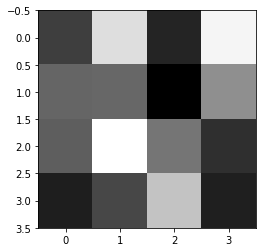

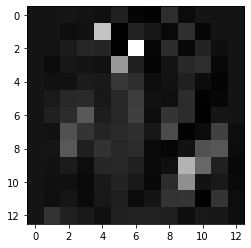

feature map min and max 0.0017484548 0.89580876

filter weight [[-0.4554781   1.1833068  -0.7105553   1.425322  ]
 [-0.05268715 -0.03273444 -1.0981154   0.37135214]
 [-0.12881345  1.5294707   0.11287885 -0.6129428 ]
 [-0.7803686  -0.3595777   0.9043796  -0.77739996]] 
bias [-0.93893176]
threshold 0.5
selected point 1 8
remaining 102 points total 169
new filter initialized, id =  33

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2224new filter generated



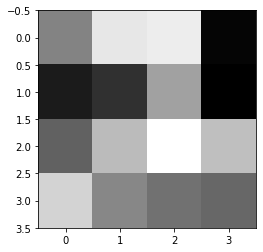

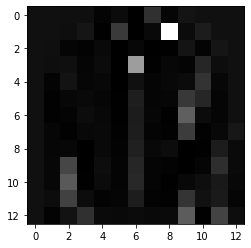

feature map min and max 1.3696477e-07 0.7985238

filter weight [[-0.09162051  1.0134368   1.0736556  -1.4827495 ]
 [-1.2452862  -0.99375445  0.23411337 -1.5442411 ]
 [-0.45266342  0.5241708   1.2804723   0.57118124]
 [ 0.7854069  -0.05261683 -0.2782803  -0.397048  ]] 
bias [-1.078747]
threshold 0.5
selected point 0 6
remaining 101 points total 169
new filter initialized, id =  34

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1604new filter generated



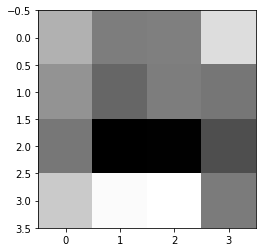

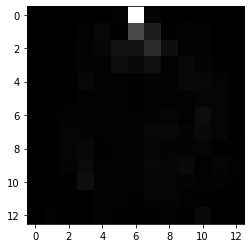

feature map min and max 0.0003598884 0.8522232

filter weight [[ 0.51524085  0.03179739  0.04743437  0.9162707 ]
 [ 0.2328751  -0.17553836  0.03486521 -0.030467  ]
 [-0.01859524 -1.1205152  -1.1093163  -0.39618757]
 [ 0.74096006  1.1910309   1.2320504   0.01870793]] 
bias [-1.9868215]
threshold 0.5
selected point 1 3
remaining 100 points total 169
new filter initialized, id =  35

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2481new filter generated



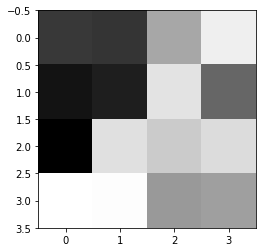

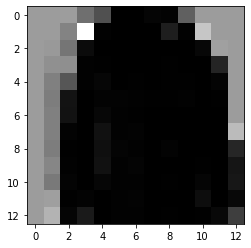

feature map min and max 4.3070048e-16 0.6551255

filter weight [[-1.5669122  -1.6086001  -0.25897926  0.58192104]
 [-1.9907297  -1.8692868   0.43423152 -1.0241603 ]
 [-2.2232428   0.40177867  0.16384508  0.3548985 ]
 [ 0.77327096  0.7428599  -0.4273625  -0.35567915]] 
bias [-0.15228449]
threshold 0.5
selected point 2 4
remaining 98 points total 169
new filter initialized, id =  36

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2938new filter generated



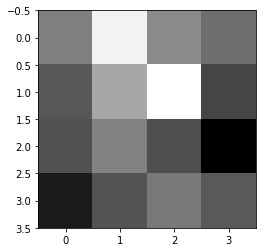

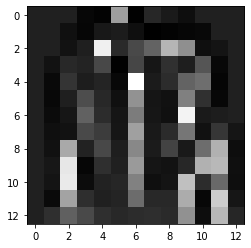

feature map min and max 0.0014016001 0.76141816

filter weight [[ 0.22146505  1.7198212   0.38368586  0.00411822]
 [-0.29563805  0.74163467  1.894493   -0.52525175]
 [-0.36529452  0.27072564 -0.40414846 -1.427533  ]
 [-1.0790367  -0.3465298   0.15905505 -0.27131432]] 
bias [-0.82045746]
threshold 0.5
selected point 2 2
remaining 92 points total 169
new filter initialized, id =  37

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1983new filter generated



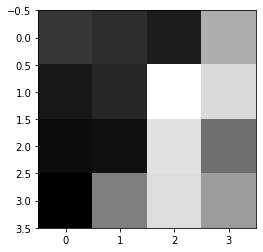

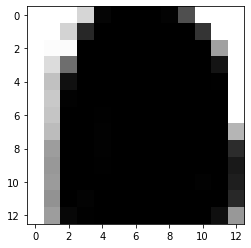

feature map min and max 5.296918e-31 0.70660734

filter weight [[-1.34259    -1.4309688  -1.5966611  -0.20421188]
 [-1.6390808  -1.4967624   0.58017623  0.21924569]
 [-1.7441354  -1.7091875   0.28747702 -0.79227465]
 [-1.8652768  -0.65746796  0.2475046  -0.38225296]] 
bias [0.28999418]
threshold 0.5
selected point 2 3
remaining 88 points total 169
new filter initialized, id =  38

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.7125new filter generated



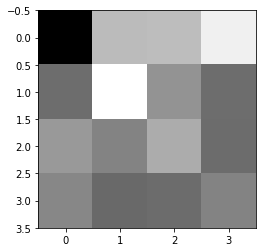

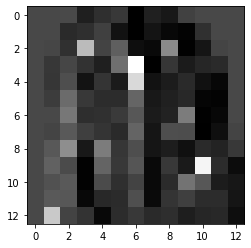

feature map min and max 2.2142836e-05 0.884508

filter weight [[-2.422725    0.6589403   0.68631464  1.5383551 ]
 [-0.6199698   1.7865101   0.00432752 -0.62059605]
 [ 0.09703852 -0.2663681   0.4135646  -0.6364203 ]
 [-0.18996881 -0.67283565 -0.6468716  -0.2668151 ]] 
bias [-0.41932744]
threshold 0.5
selected point 1 7
remaining 86 points total 169
new filter initialized, id =  39

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2381new filter generated



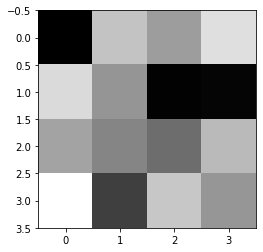

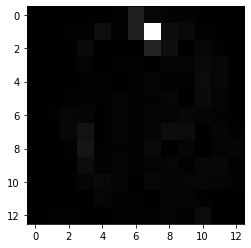

feature map min and max 0.00031461037 0.82177114

filter weight [[-1.2100339   0.6341634   0.27117714  0.89065343]
 [ 0.8448158   0.19260481 -1.1860641  -1.1567882 ]
 [ 0.32880372  0.04758327 -0.18076602  0.5479265 ]
 [ 1.198716   -0.615695    0.6665139   0.20337546]] 
bias [-1.8433365]
threshold 0.5
selected point 2 10
remaining 85 points total 169
new filter initialized, id =  40

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1728new filter generated



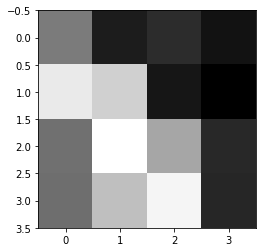

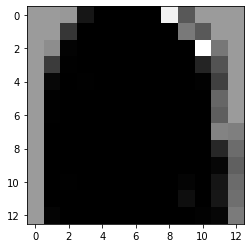

feature map min and max 0.0 0.7147333

filter weight [[-0.6324042  -1.8235215  -1.6264731  -1.9433627 ]
 [ 0.7470052   0.4306623  -1.8971883  -2.1778247 ]
 [-0.7728193   1.0179898  -0.09879797 -1.671921  ]
 [-0.80168706  0.20961247  0.8889282  -1.7027545 ]] 
bias [-0.0999027]
threshold 0.5
selected point 2 9
remaining 84 points total 169
new filter initialized, id =  41

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1621new filter generated



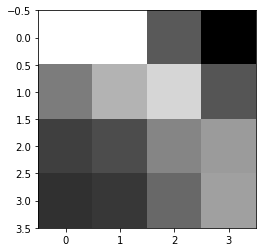

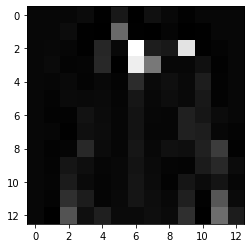

feature map min and max 7.266182e-05 0.9720846

filter weight [[ 1.7285655   1.7246809  -0.42444956 -1.5837917 ]
 [ 0.02374708  0.74509037  1.1864524  -0.48241708]
 [-0.7640831  -0.5953799   0.14631276  0.43403506]
 [-0.95574415 -0.8676092  -0.23509961  0.48733735]] 
bias [-1.2539034]
threshold 0.5
selected point 3 2
remaining 83 points total 169
new filter initialized, id =  42

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1805new filter generated



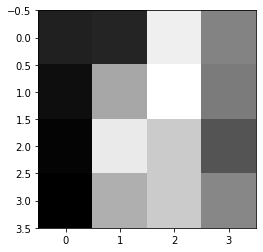

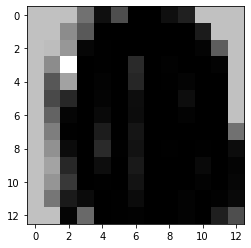

feature map min and max 2.994316e-19 0.71965003

filter weight [[-1.8041137  -1.759308    0.8803308  -0.5155501 ]
 [-2.0385592  -0.05461989  1.0926133  -0.627159  ]
 [-2.1773117   0.80899984  0.409287   -1.1397018 ]
 [-2.231169    0.04621786  0.4140282  -0.47478217]] 
bias [0.06146794]
threshold 0.5
selected point 3 4
remaining 82 points total 169
new filter initialized, id =  43

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.8336new filter generated



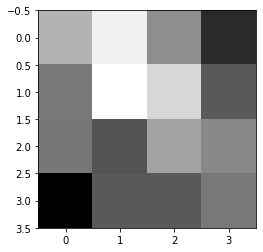

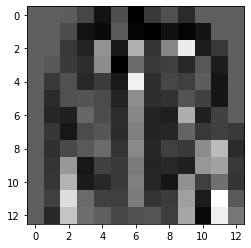

feature map min and max 0.001183005 0.931016

filter weight [[ 0.55742747  1.3455594   0.09486984 -1.1664202 ]
 [-0.15905155  1.5246291   1.0214682  -0.55085623]
 [-0.19051898 -0.6436839   0.34778517  0.01724485]
 [-1.6950576  -0.5708229  -0.5707873  -0.17666091]] 
bias [-0.24050751]
threshold 0.5
selected point 3 8
remaining 77 points total 169
new filter initialized, id =  44

combined training
 99/100 [============================>.] - ETA: 0s - loss: 2.1027new filter generated



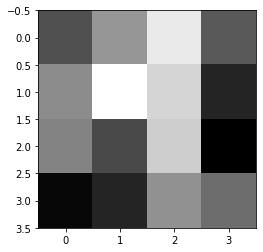

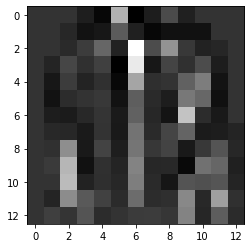

feature map min and max 0.019304086 0.990798

filter weight [[-0.29406846  0.23761171  0.87229306 -0.22335215]
 [ 0.16196014  1.030533    0.7110782  -0.6161775 ]
 [ 0.09766943 -0.3341739   0.6570611  -0.8967915 ]
 [-0.8369911  -0.6148265   0.19901636 -0.07027685]] 
bias [-0.49032807]
threshold 0.5
selected point 3 9
remaining 76 points total 169
new filter initialized, id =  45

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.9012new filter generated



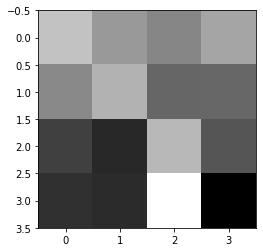

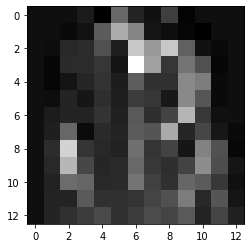

feature map min and max 0.02973807 0.78518766

filter weight [[ 0.7715358   0.4199406   0.25737226  0.5190915 ]
 [ 0.28246224  0.637125   -0.01641276 -0.01373031]
 [-0.34334213 -0.55382985  0.68704087 -0.17032568]
 [-0.47982576 -0.52988136  1.3003824  -0.9026125 ]] 
bias [-0.9416362]
threshold 0.5
selected point 3 3
remaining 74 points total 169
new filter initialized, id =  46

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.9223new filter generated



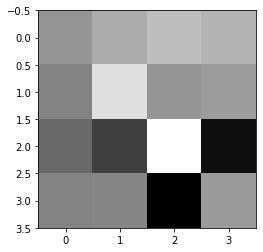

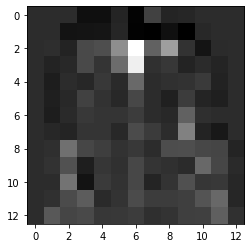

feature map min and max 0.025634414 0.89809054

filter weight [[ 0.12802492  0.33163184  0.514771    0.4064043 ]
 [-0.04141223  0.8284688   0.12352798  0.19416502]
 [-0.2950425  -0.6781389   1.1384777  -1.1488197 ]
 [-0.03482612 -0.01737935 -1.2960467   0.186089  ]] 
bias [-0.5765997]
threshold 0.5
selected point 3 8
remaining 74 points total 169
x is already in sample space
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 47
min and max 0.21806113 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


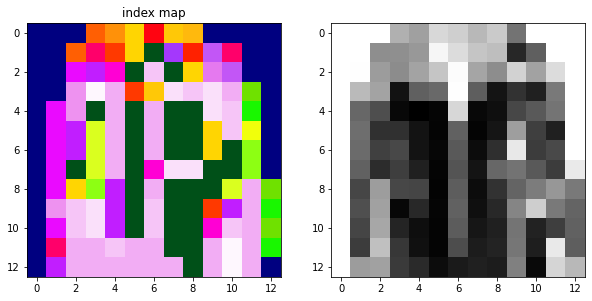

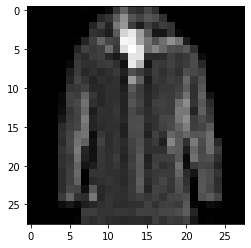

In [14]:
show_all_index_maps(new_model, images_x_0_9)
img_4 = images_x_0_9[4].reshape(28,28)
new_model = generate_model(img_4, model = new_model)
show_indedx_act_map(new_model, img_4)
plt.imshow(img_4.reshape(28,28), cmap='gray')
plt.show()

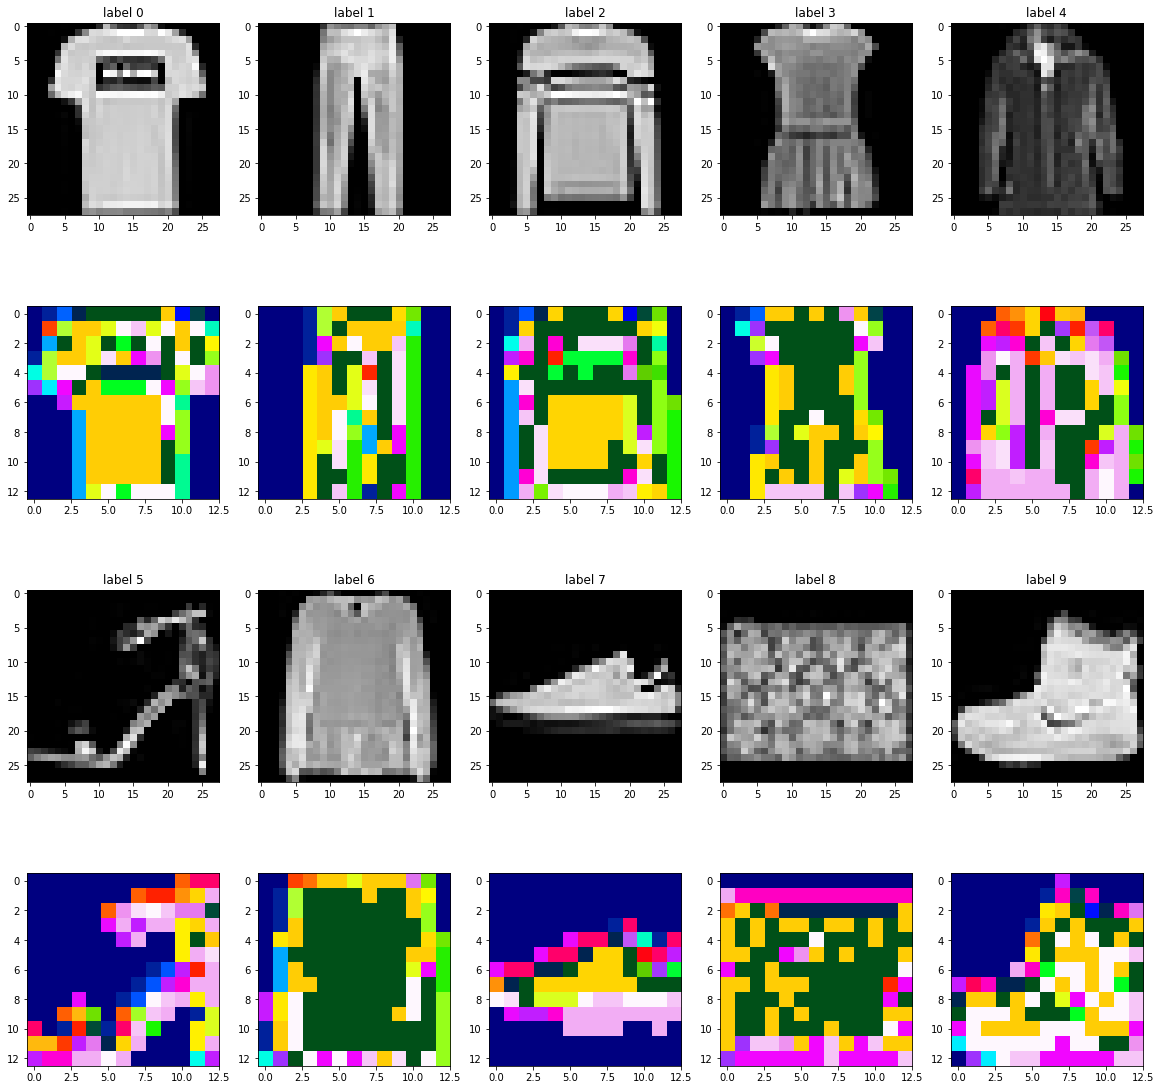

min and max 0.28871524 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


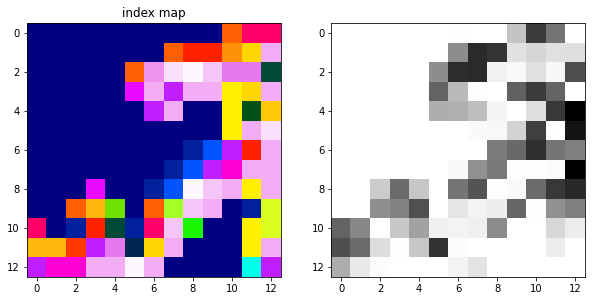

activation and threshold
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 0.5
selected point 1 7
remaining 15 points total 169
new filter initialized, id =  47

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0182new filter generated



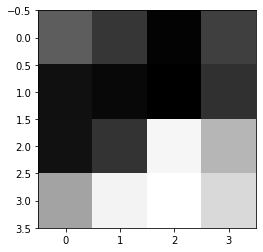

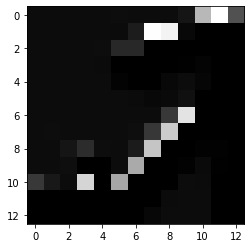

feature map min and max 4.0962975e-38 0.99945736

filter weight [[-0.8083442  -1.3208523  -1.9928215  -1.2104343 ]
 [-1.8182192  -1.9258901  -2.0382745  -1.4026439 ]
 [-1.8037418  -1.3636118   1.1925389   0.35466838]
 [ 0.11838789  1.1591172   1.3131189   0.80629563]] 
bias [-1.0853716]
threshold 0.5
selected point 2 6
remaining 12 points total 169
new filter initialized, id =  48

combined training
 99/100 [============================>.] - ETA: 0s - loss: 2.3030new filter generated



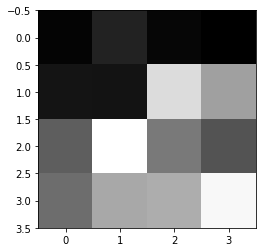

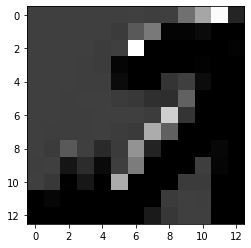

feature map min and max 2.1335713e-30 0.8442401

filter weight [[-2.1927295  -1.7735035  -2.1681664  -2.2577453 ]
 [-1.9666518  -1.9842957   0.855798    0.00260666]
 [-0.9320773   1.3518872  -0.54216516 -1.0847448 ]
 [-0.7083986   0.11398701  0.1868464   1.2443054 ]] 
bias [-0.5089405]
threshold 0.5
selected point 2 7
remaining 11 points total 169
new filter initialized, id =  49

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.1062new filter generated



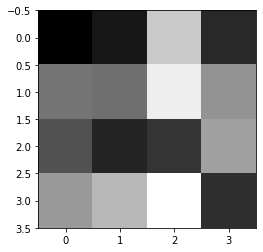

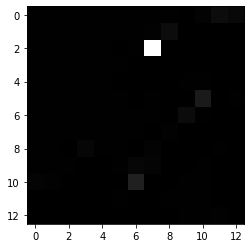

feature map min and max 1.3412292e-08 0.9551282

filter weight [[-1.4541875  -1.1913157   0.8453382  -0.98172057]
 [-0.12620035 -0.17909831  1.2607027   0.24162301]
 [-0.52881336 -1.0369483  -0.8599153   0.37107846]
 [ 0.29506135  0.6502185   1.4652561  -0.92257124]] 
bias [-1.8269409]
threshold 0.5
selected point 5 12
remaining 10 points total 169
new filter initialized, id =  50

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2649new filter generated



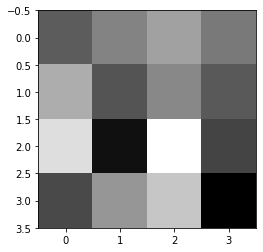

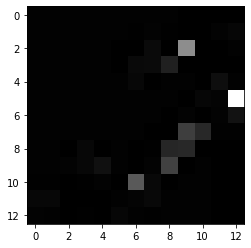

feature map min and max 1.8758188e-08 0.92546743

filter weight [[-0.603797    0.10787407  0.615572   -0.06155576]
 [ 0.83244264 -0.73605996  0.17496856 -0.6445745 ]
 [ 1.6910024  -1.9358836   2.2869415  -1.021249  ]
 [-0.9261263   0.4258112   1.2732154  -2.2311473 ]] 
bias [-1.6297791]
threshold 0.5
selected point 5 10
remaining 9 points total 169
new filter initialized, id =  51

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0357new filter generated



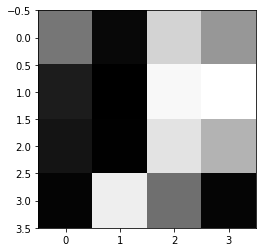

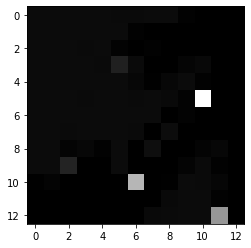

feature map min and max 6.7563736e-26 0.90210843

filter weight [[-0.47053692 -1.6708694   0.55523473 -0.1058246 ]
 [-1.4478155  -1.7579111   0.9408292   1.0256221 ]
 [-1.5353179  -1.7403255   0.7182184   0.19110653]
 [-1.7054878   0.8329228  -0.55018044 -1.6962156 ]] 
bias [-1.1653818]
threshold 0.5
selected point 4 12
remaining 8 points total 169
new filter initialized, id =  52

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.2738new filter generated



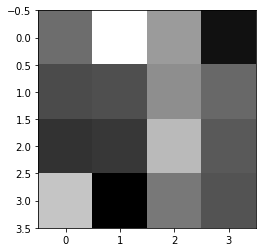

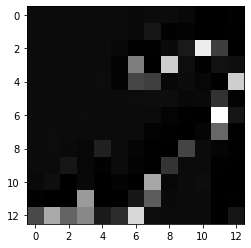

feature map min and max 1.5709942e-06 0.9950966

filter weight [[ 0.00286824  2.6568604   0.8392056  -1.6512812 ]
 [-0.61807626 -0.53493273  0.5957736  -0.08121444]
 [-1.0631263  -0.97941184  1.4034029  -0.34308827]
 [ 1.5969336  -1.976194    0.20596741 -0.46138066]] 
bias [-1.1171925]
threshold 0.5
selected point 6 10
remaining 7 points total 169
new filter initialized, id =  53

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0352new filter generated



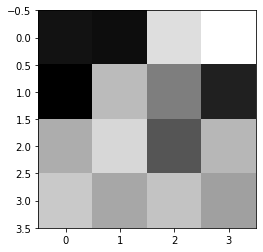

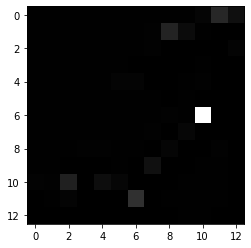

feature map min and max 1.151493e-16 0.95402426

filter weight [[-1.8698323  -1.9342427   0.9384269   1.3951735 ]
 [-2.1169522   0.44913572 -0.37739822 -1.6615056 ]
 [ 0.2689407   0.84215695 -0.94978505  0.3992586 ]
 [ 0.6506517   0.18765008  0.5803175   0.08383058]] 
bias [-1.8117403]
threshold 0.5
selected point 7 12
remaining 6 points total 169
new filter initialized, id =  54

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.0873new filter generated



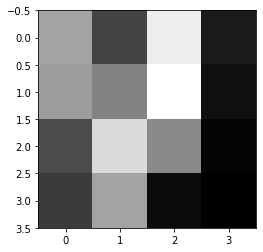

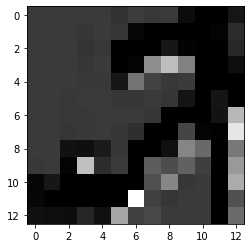

feature map min and max 1.1364837e-19 0.9750894

filter weight [[ 0.5457846  -1.1890019   1.8789686  -1.929219  ]
 [ 0.4459828  -0.00967759  2.2228925  -2.1382668 ]
 [-1.0255073   1.5418121   0.08458976 -2.331145  ]
 [-1.3301531   0.560644   -2.204585   -2.4173582 ]] 
bias [-0.4794815]
threshold 0.5
selected point 8 12
remaining 5 points total 169
new filter initialized, id =  55

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.5707new filter generated



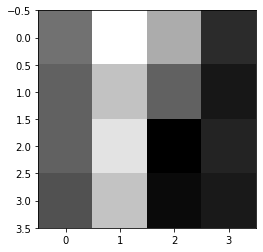

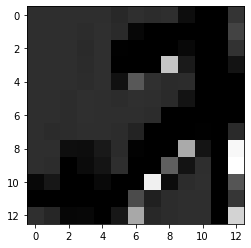

feature map min and max 1.5650737e-23 0.9045788

filter weight [[-0.4840267   1.8665972   0.49175966 -1.6192656 ]
 [-0.7388112   0.85256153 -0.7331807  -1.9512901 ]
 [-0.74311215  1.4217863  -2.3426852  -1.7663083 ]
 [-0.98460245  0.8643769  -2.1661534  -1.9191613 ]] 
bias [-0.6183327]
threshold 0.5
selected point 4 11
remaining 4 points total 169
new filter initialized, id =  56

combined training
 99/100 [============================>.] - ETA: 0s - loss: 1.4732new filter generated



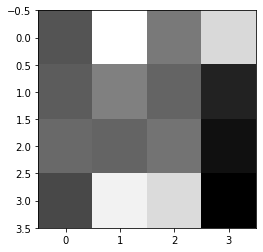

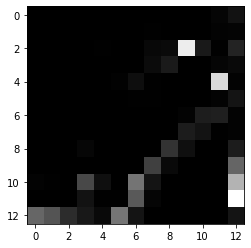

feature map min and max 9.726276e-07 0.9993283

filter weight [[-0.32679194  1.8016396   0.1345692   1.3274323 ]
 [-0.22561128  0.21895884 -0.1203518  -0.93729395]
 [-0.06533619 -0.13003176  0.06661079 -1.1622331 ]
 [-0.47180054  1.63726     1.3546724  -1.3698678 ]] 
bias [-1.8602183]
threshold 0.5
selected point 11 5
remaining 3 points total 169
new filter initialized, id =  57

combined training
  8/100 [=>............................] - ETA: 1:35 - loss: 1.2933

KeyboardInterrupt: 

In [15]:
show_all_index_maps(new_model, images_x_0_9)

img_5 = images_x_0_9[5].reshape(28,28)
show_indedx_act_map(new_model, img_5)
new_model = generate_model(img_5, model = new_model)
show_indedx_act_map(new_model, img_5)
plt.imshow(img_5.reshape(28,28), cmap='gray')
plt.show()

show_all_index_maps(new_model, images_x_0_9)


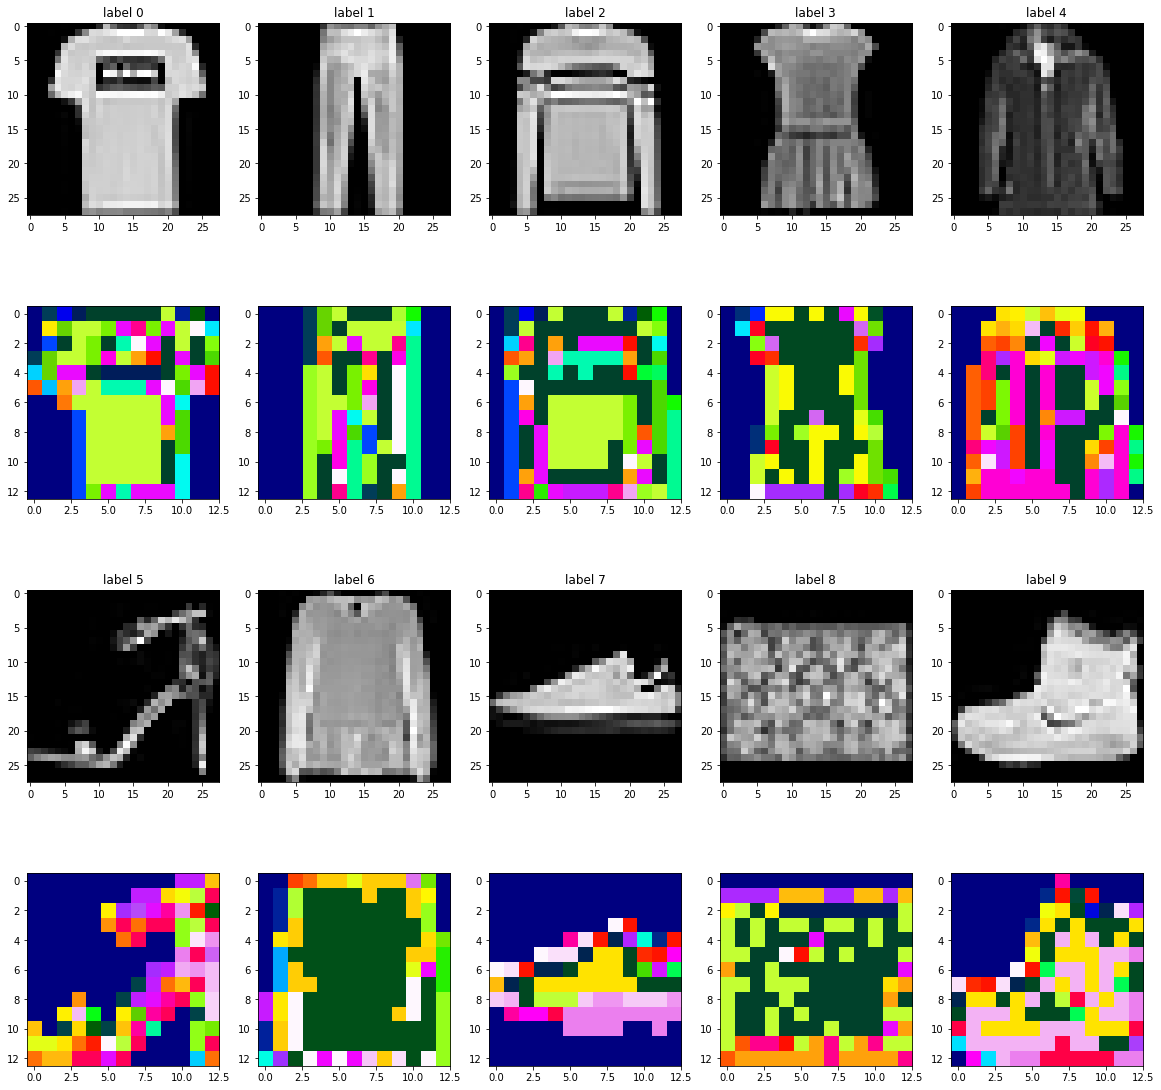

min and max 0.48242322 1.0


C:\Users\Yunjie Zhu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:411: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


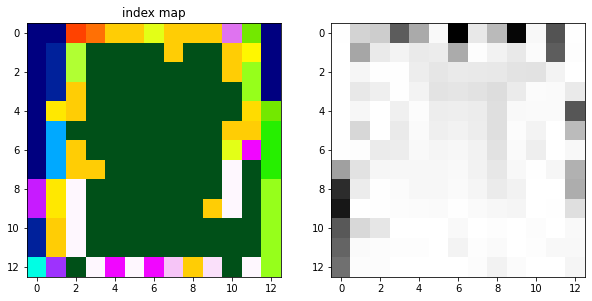

activation and threshold
<function gaussian_activation_01 at 0x000001BAD6A1CD38> 0.5
selected point 0 9
remaining 2 points total 169
new filter initialized, id =  58

combined training


KeyError: 57

In [16]:
show_all_index_maps(new_model, images_x_0_9)

img_6 = images_x_0_9[6].reshape(28,28)
show_indedx_act_map(new_model, img_6)
new_model = generate_model(img_6, model = new_model)
show_indedx_act_map(new_model, img_6)
plt.imshow(img_6.reshape(28,28), cmap='gray')
plt.show()

show_all_index_maps(new_model, images_x_0_9)


In [17]:
backend_model = tf.keras.Sequential([ tf.keras.layers.Flatten(),tf.keras.layers.Dense(1024, activation = "sigmoid"), tf.keras.layers.Dense(512, activation = "sigmoid"), tf.keras.layers.Dense(512, activation = "sigmoid"), tf.keras.layers.Dense(10, activation='softmax')])
backend_model.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

def train_one_shot(sample_x, target_y, my_model, backend_model):
    #call the model to get the feature maps
    feature_maps = tf.convert_to_tensor(my_model.call(sample_x).numpy().astype('float64'))
    #show the plotting of the feature maps
    #show_heatmap_feature_maps(feature_maps)
    target_y = tf.convert_to_tensor(target_y)
    #print(type(feature_maps))
    
    #fed the feature maps to the backend model
    
    
    backend_model.fit(feature_maps, target_y, epochs=1, verbose=0)
    



In [18]:
batch = 0
for epoch in tqdm.tqdm(range(20*n_shot)):
    for batch in range(n_shot): #training all the classes for one round is necessary, to avoid unbalanced training and overfitting
        
        for i in range(0, len(images_x_0_9), n_shot):
            #print(i + batch)
            train_one_shot(images_x_0_9[i + batch], images_y_0_9[i + batch], my_model, backend_model)
            

  0%|          | 0/20 [00:00<?, ?it/s]

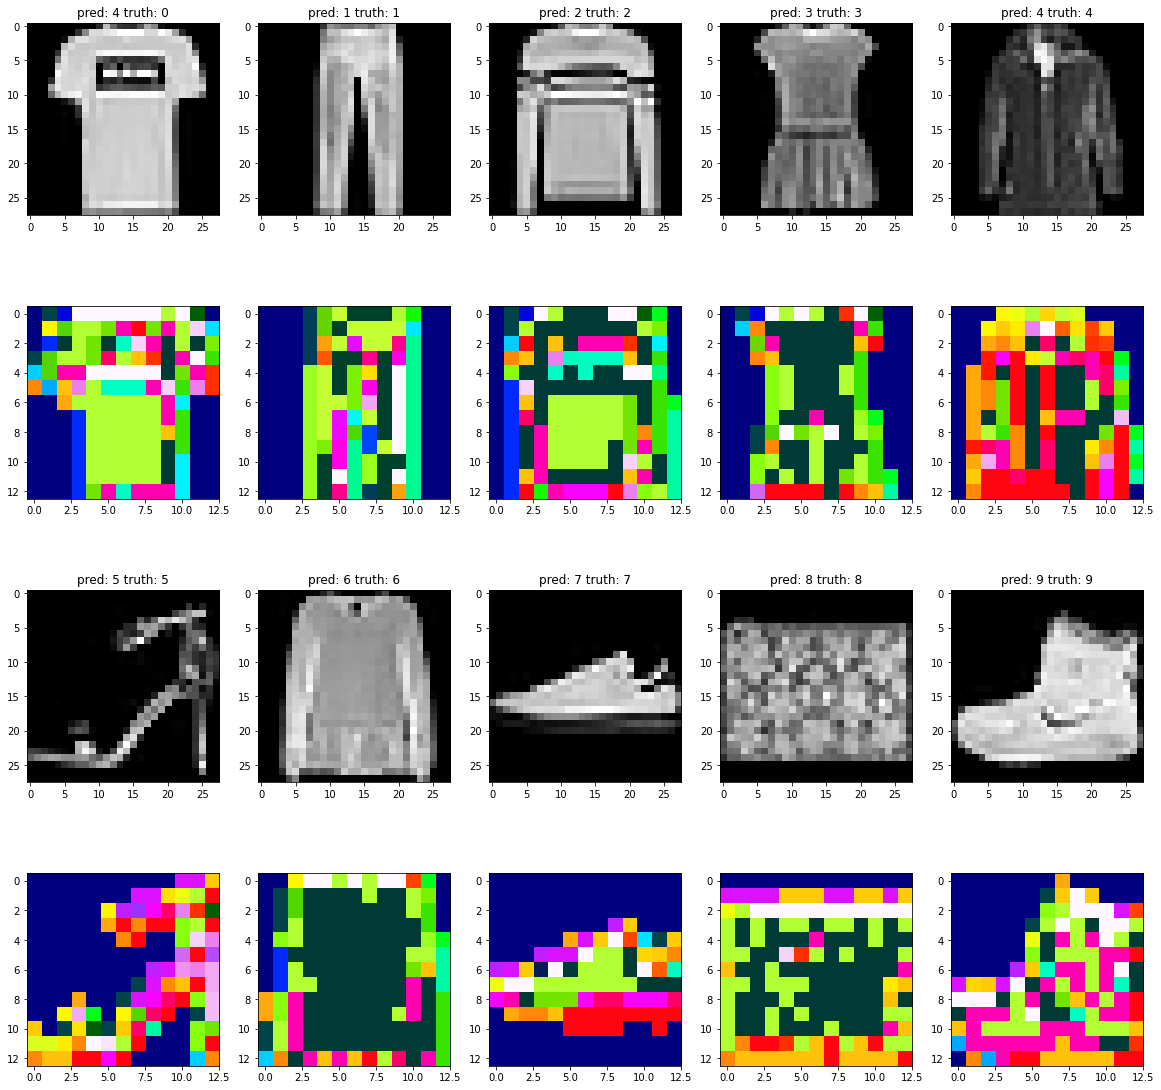

accuracy 0.9


In [19]:
#show the heatmap of 10 images
#show 20 images
figure = plt.figure(figsize=(20, 20))

'''
for i in range(10):
    feature_maps = tf.convert_to_tensor(my_model.call(images_x_0_9[i]).numpy().astype('float64'))
    show_heatmap_feature_maps(feature_maps)
    #plot original image
    plt.imshow(images_x_0_9[i].reshape(28,28), cmap='gray')
    plt.show()
    print("prediction", backend_model.predict(feature_maps).argmax())
    print("ground truth", images_y_0_9[i].argmax())
'''

#show the heatmap of 10 images and 10 original images
#5 images one row
correct = 0
for i in range(len(images_x_0_9)):
    feature_maps = tf.convert_to_tensor(my_model.call(images_x_0_9[i]).numpy().astype('float64'))
    #show_heatmap_feature_maps(feature_maps)
    #plot original image
    
    plt.subplot((len(images_x_0_9) * 2) // 5, 5, i+1 + (i // 5) * 5)
    plt.imshow(images_x_0_9[i].reshape(28,28), cmap='gray')
    plt.title("pred: " + str(backend_model.predict(feature_maps).argmax()) + " truth: " + str(images_y_0_9[i].argmax()))
    plt.subplot((len(images_x_0_9) * 2) // 5, 5, i+6 + (i // 5) * 5)
    index_map = np.argmax(feature_maps, axis = 3).reshape(np.shape(feature_maps)[1:-1])
    plt.imshow(index_map, cmap='gist_ncar')
    correct += (backend_model.predict(feature_maps).argmax() == images_y_0_9[i].argmax())
plt.show()

print("accuracy", correct / len(images_x_0_9))


In [20]:
#evaluate the model on the test set

def evaluation(my_model, backend_model):
    confusion_matrix = [[0 for i in range(10)] for j in range(10)]
    
    for i in tqdm.tqdm(range(test_images.shape[0]), desc = "accuracy"):
        feature_maps = tf.convert_to_tensor(my_model.call(test_images[i].reshape(1,28,28,1).astype('float64')).numpy().astype('float64'))
        prediction = int(backend_model.predict(feature_maps).argmax())
        
        confusion_matrix[int(test_labels[i])][prediction] += 1
        acc = np.trace(confusion_matrix)/np.sum(confusion_matrix)
        tqdm.tqdm.write("accuracy: " + str(acc))
    return confusion_matrix

conf_mat = evaluation(my_model, backend_model)

#show the confusion matrix
plt.imshow(conf_mat, cmap='gray')
plt.show()

#show the accuracy
print("accuracy", np.trace(conf_mat)/np.sum(conf_mat))
#show best classified and worst classified
best_classified = np.argmax(np.diag(conf_mat))
worst_classified = np.argmin(np.diag(conf_mat))
print("best classified", best_classified)
print("worst classified", worst_classified)

#plot images of best classified and worst classified
plt.imshow(test_images[np.where(test_labels == best_classified)[0][0]].reshape(28,28), cmap='gray')
plt.show()
plt.imshow(test_images[np.where(test_labels == worst_classified)[0][0]].reshape(28,28), cmap='gray')
plt.show()
#print shape of the feature maps
print(my_model.call(images_x_0_9[0]).shape)

#show the index map of best classified
show_indedx_act_map(my_model, test_images[np.where(test_labels == best_classified)[0][0]])
#show the index map of worst classified
show_indedx_act_map(my_model, test_images[np.where(test_labels == worst_classified)[0][0]])

accuracy:   0%|          | 0/10000 [00:00<?, ?it/s]

accuracy: 0.0
accuracy: 0.5
accuracy: 0.6666666666666666
accuracy: 0.75
accuracy: 0.8
accuracy: 0.8333333333333334
accuracy: 0.8571428571428571
accuracy: 0.75
accuracy: 0.6666666666666666
accuracy: 0.7
accuracy: 0.6363636363636364
accuracy: 0.5833333333333334
accuracy: 0.6153846153846154
accuracy: 0.5714285714285714
accuracy: 0.5333333333333333
accuracy: 0.5625
accuracy: 0.5294117647058824
accuracy: 0.5
accuracy: 0.47368421052631576
accuracy: 0.45
accuracy: 0.42857142857142855
accuracy: 0.4090909090909091
accuracy: 0.43478260869565216
accuracy: 0.4166666666666667
accuracy: 0.44
accuracy: 0.46153846153846156
accuracy: 0.48148148148148145
accuracy: 0.4642857142857143
accuracy: 0.4482758620689655
accuracy: 0.43333333333333335
accuracy: 0.41935483870967744
accuracy: 0.40625
accuracy: 0.3939393939393939
accuracy: 0.38235294117647056
accuracy: 0.37142857142857144
accuracy: 0.3611111111111111
accuracy: 0.3783783783783784
accuracy: 0.3684210526315789
accuracy: 0.38461538461538464
accuracy: 0.4

KeyboardInterrupt: 

In [ ]:
#_______________________________________________________________
# TODO: Exp 1: use a CNN backend model
# TODO: Exp 2: increase the tile_level in activation function
# TODO: Exp 3: use 3x3 kernel size
# TODO: Exp 4: switch back to sigmoid activation function, with 3x3 kernel size
# TODO: Exp 5: If all the above fails, try to develop a incremental learning directly
#_______________________________________________________________

In [21]:
feature_maps_0_9 = []
for i in range(10):
    img_i = images_x_0_9[i]
    feature_maps_0_9.append(my_model.call(img_i.reshape(1,28,28,1).astype('float64')).numpy().astype('float64'))
    
feature_maps_0_9 = np.array(feature_maps_0_9)
print(feature_maps_0_9.shape)

#call the model, get the 10 feature maps
#train a 
#train another conv layer over it, either generative model or ordinary model






(10, 1, 13, 13, 59)


In [22]:
channel_count = feature_maps_0_9.shape[-1]

#a sequential model with 2 conv layers

backend_conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (4,4),strides=(2,2), activation='sigmoid', input_shape=(feature_maps_0_9.shape[1:-1] + (channel_count,))),
    #tf.keras.layers.Conv2D(32, (3,3), activation='sigmoid'),
    #max pooling
    #tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.Conv2D(32, (3,3), activation='sigmoid'),
    #tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#compile the model
backend_conv_model.compile(optimizer='adam',
                loss='MSE',
                metrics=['accuracy'])




In [23]:
backend_conv_model.fit(np.array(feature_maps_0_9), np.array(images_y_0_9).reshape(10, 10), epochs=200, verbose=1, validation_data=(np.array(feature_maps_0_9), np.array(images_y_0_9).reshape(10, 10)))




Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.0924 - accuracy: 0.1000 - val_loss: 0.0911 - val_accuracy: 0.1000
Epoch 2/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0911 - accuracy: 0.1000 - val_loss: 0.0909 - val_accuracy: 0.1000
Epoch 3/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0909 - accuracy: 0.1000 - val_loss: 0.0909 - val_accuracy: 0.2000
Epoch 4/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0909 - accuracy: 0.2000 - val_loss: 0.0908 - val_accuracy: 0.1000
Epoch 5/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0908 - accuracy: 0.1000 - val_loss: 0.0908 - val_accuracy: 0.1000
Epoch 6/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0908 - accuracy: 0.1000 - val_loss: 0.0906 - val_accuracy: 0.1000
Epoch 7/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0906 - accuracy: 0.1000 - val_loss: 0.0904 - val_accuracy: 0.1000
Epoch 8/200
1/1 [=====

In [24]:
#evaluate the model on the test set

#get feature maps of the test images

feature_maps_test = []

for i in tqdm.tqdm(range(test_images.shape[0])):
    feature_maps_test.append(my_model.call(test_images[i].reshape(1,28,28,1).astype('float64')).numpy().astype('float64'))

feature_maps_test = np.array(feature_maps_test)

#evaluate the model on the test set
prediction_test = backend_conv_model.predict(feature_maps_test)

#show the confusion matrix
conf_mat_conv = [[0 for i in range(10)] for j in range(10)]
for i in range(test_images.shape[0]):
    conf_mat_conv[int(test_labels[i])][int(prediction_test[i].argmax())] += 1




  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
#evaluate the model on the test set
prediction_test = backend_conv_model.predict(feature_maps_test)

#show the confusion matrix
conf_mat_conv = [[0 for i in range(10)] for j in range(10)]
for i in range(test_images.shape[0]):
    conf_mat_conv[int(test_labels[i])][int(prediction_test[i].argmax())] += 1

ValueError: in user code:

    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\Yunjie Zhu\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:207 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer sequential_1 expects 1 input(s), but it received 3331 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:300' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:301' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:302' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:303' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:304' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:305' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:306' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:307' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:308' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:309' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:310' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:311' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:312' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:313' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:314' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:315' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:316' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:317' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:318' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:319' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:320' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:321' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:322' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:323' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:324' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:325' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:326' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:327' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:328' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:329' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:330' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:331' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:332' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:333' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:334' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:335' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:336' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:337' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:338' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:339' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:340' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:341' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:342' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:343' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:344' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:345' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:346' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:347' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:348' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:349' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:350' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:351' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:352' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:353' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:354' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:355' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:356' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:357' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:358' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:359' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:360' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:361' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:362' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:363' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:364' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:365' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:366' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:367' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:368' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:369' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:370' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:371' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:372' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:373' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:374' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:375' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:376' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:377' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:378' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:379' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:380' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:381' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:382' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:383' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:384' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:385' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:386' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:387' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:388' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:389' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:390' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:391' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:392' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:393' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:394' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:395' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:396' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:397' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:398' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:399' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:400' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:401' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:402' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:403' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:404' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:405' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:406' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:407' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:408' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:409' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:410' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:411' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:412' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:413' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:414' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:415' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:416' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:417' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:418' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:419' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:420' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:421' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:422' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:423' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:424' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:425' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:426' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:427' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:428' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:429' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:430' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:431' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:432' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:433' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:434' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:435' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:436' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:437' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:438' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:439' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:440' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:441' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:442' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:443' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:444' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:445' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:446' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:447' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:448' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:449' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:450' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:451' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:452' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:453' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:454' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:455' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:456' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:457' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:458' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:459' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:460' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:461' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:462' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:463' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:464' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:465' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:466' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:467' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:468' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:469' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:470' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:471' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:472' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:473' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:474' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:475' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:476' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:477' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:478' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:479' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:480' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:481' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:482' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:483' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:484' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:485' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:486' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:487' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:488' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:489' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:490' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:491' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:492' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:493' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:494' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:495' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:496' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:497' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:498' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:499' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:500' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:501' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:502' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:503' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:504' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:505' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:506' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:507' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:508' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:509' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:510' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:511' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:512' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:513' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:514' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:515' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:516' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:517' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:518' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:519' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:520' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:521' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:522' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:523' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:524' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:525' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:526' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:527' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:528' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:529' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:530' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:531' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:532' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:533' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:534' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:535' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:536' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:537' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:538' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:539' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:540' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:541' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:542' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:543' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:544' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:545' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:546' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:547' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:548' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:549' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:550' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:551' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:552' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:553' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:554' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:555' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:556' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:557' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:558' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:559' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:560' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:561' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:562' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:563' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:564' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:565' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:566' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:567' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:568' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:569' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:570' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:571' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:572' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:573' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:574' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:575' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:576' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:577' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:578' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:579' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:580' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:581' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:582' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:583' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:584' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:585' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:586' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:587' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:588' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:589' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:590' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:591' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:592' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:593' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:594' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:595' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:596' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:597' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:598' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:599' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:600' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:601' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:602' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:603' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:604' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:605' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:606' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:607' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:608' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:609' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:610' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:611' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:612' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:613' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:614' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:615' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:616' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:617' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:618' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:619' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:620' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:621' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:622' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:623' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:624' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:625' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:626' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:627' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:628' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:629' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:630' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:631' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:632' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:633' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:634' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:635' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:636' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:637' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:638' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:639' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:640' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:641' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:642' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:643' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:644' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:645' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:646' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:647' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:648' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:649' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:650' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:651' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:652' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:653' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:654' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:655' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:656' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:657' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:658' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:659' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:660' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:661' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:662' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:663' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:664' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:665' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:666' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:667' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:668' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:669' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:670' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:671' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:672' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:673' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:674' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:675' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:676' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:677' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:678' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:679' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:680' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:681' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:682' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:683' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:684' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:685' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:686' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:687' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:688' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:689' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:690' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:691' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:692' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:693' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:694' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:695' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:696' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:697' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:698' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:699' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:700' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:701' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:702' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:703' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:704' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:705' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:706' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:707' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:708' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:709' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:710' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:711' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:712' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:713' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:714' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:715' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:716' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:717' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:718' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:719' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:720' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:721' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:722' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:723' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:724' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:725' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:726' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:727' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:728' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:729' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:730' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:731' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:732' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:733' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:734' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:735' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:736' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:737' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:738' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:739' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:740' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:741' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:742' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:743' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:744' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:745' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:746' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:747' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:748' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:749' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:750' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:751' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:752' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:753' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:754' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:755' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:756' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:757' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:758' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:759' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:760' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:761' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:762' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:763' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:764' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:765' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:766' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:767' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:768' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:769' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:770' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:771' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:772' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:773' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:774' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:775' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:776' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:777' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:778' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:779' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:780' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:781' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:782' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:783' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:784' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:785' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:786' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:787' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:788' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:789' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:790' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:791' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:792' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:793' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:794' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:795' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:796' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:797' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:798' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:799' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:800' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:801' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:802' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:803' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:804' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:805' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:806' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:807' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:808' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:809' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:810' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:811' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:812' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:813' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:814' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:815' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:816' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:817' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:818' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:819' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:820' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:821' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:822' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:823' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:824' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:825' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:826' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:827' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:828' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:829' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:830' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:831' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:832' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:833' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:834' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:835' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:836' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:837' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:838' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:839' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:840' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:841' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:842' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:843' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:844' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:845' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:846' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:847' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:848' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:849' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:850' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:851' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:852' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:853' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:854' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:855' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:856' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:857' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:858' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:859' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:860' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:861' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:862' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:863' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:864' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:865' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:866' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:867' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:868' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:869' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:870' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:871' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:872' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:873' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:874' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:875' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:876' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:877' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:878' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:879' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:880' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:881' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:882' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:883' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:884' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:885' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:886' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:887' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:888' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:889' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:890' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:891' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:892' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:893' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:894' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:895' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:896' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:897' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:898' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:899' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:900' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:901' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:902' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:903' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:904' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:905' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:906' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:907' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:908' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:909' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:910' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:911' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:912' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:913' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:914' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:915' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:916' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:917' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:918' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:919' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:920' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:921' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:922' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:923' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:924' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:925' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:926' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:927' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:928' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:929' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:930' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:931' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:932' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:933' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:934' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:935' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:936' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:937' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:938' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:939' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:940' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:941' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:942' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:943' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:944' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:945' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:946' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:947' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:948' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:949' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:950' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:951' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:952' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:953' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:954' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:955' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:956' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:957' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:958' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:959' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:960' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:961' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:962' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:963' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:964' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:965' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:966' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:967' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:968' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:969' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:970' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:971' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:972' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:973' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:974' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:975' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:976' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:977' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:978' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:979' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:980' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:981' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:982' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:983' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:984' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:985' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:986' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:987' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:988' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:989' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:990' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:991' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:992' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:993' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:994' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:995' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:996' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:997' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:998' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:999' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1000' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1001' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1002' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1003' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1004' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1005' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1006' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1007' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1008' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1009' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1010' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1011' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1012' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1013' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1014' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1015' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1016' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1017' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1018' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1019' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1020' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1021' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1022' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1023' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1024' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1025' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1026' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1027' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1028' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1029' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1030' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1031' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1032' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1033' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1034' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1035' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1036' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1037' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1038' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1039' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1040' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1041' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1042' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1043' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1044' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1045' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1046' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1047' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1048' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1049' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1050' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1051' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1052' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1053' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1054' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1055' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1056' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1057' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1058' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1059' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1060' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1061' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1062' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1063' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1064' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1065' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1066' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1067' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1068' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1069' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1070' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1071' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1072' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1073' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1074' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1075' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1076' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1077' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1078' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1079' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1080' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1081' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1082' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1083' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1084' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1085' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1086' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1087' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1088' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1089' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1090' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1091' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1092' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1093' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1094' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1095' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1096' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1097' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1098' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1099' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1100' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1101' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1102' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1103' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1104' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1105' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1106' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1107' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1108' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1109' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1110' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1111' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1112' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1113' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1114' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1115' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1116' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1117' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1118' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1119' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1120' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1121' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1122' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1123' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1124' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1125' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1126' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1127' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1128' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1129' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1130' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1131' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1132' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1133' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1134' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1135' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1136' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1137' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1138' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1139' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1140' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1141' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1142' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1143' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1144' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1145' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1146' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1147' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1148' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1149' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1150' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1151' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1152' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1153' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1154' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1155' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1156' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1157' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1158' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1159' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1160' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1161' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1162' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1163' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1164' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1165' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1166' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1167' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1168' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1169' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1170' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1171' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1172' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1173' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1174' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1175' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1176' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1177' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1178' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1179' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1180' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1181' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1182' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1183' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1184' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1185' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1186' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1187' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1188' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1189' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1190' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1191' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1192' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1193' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1194' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1195' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1196' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1197' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1198' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1199' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1200' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1201' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1202' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1203' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1204' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1205' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1206' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1207' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1208' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1209' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1210' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1211' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1212' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1213' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1214' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1215' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1216' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1217' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1218' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1219' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1220' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1221' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1222' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1223' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1224' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1225' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1226' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1227' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1228' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1229' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1230' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1231' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1232' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1233' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1234' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1235' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1236' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1237' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1238' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1239' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1240' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1241' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1242' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1243' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1244' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1245' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1246' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1247' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1248' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1249' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1250' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1251' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1252' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1253' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1254' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1255' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1256' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1257' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1258' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1259' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1260' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1261' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1262' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1263' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1264' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1265' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1266' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1267' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1268' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1269' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1270' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1271' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1272' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1273' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1274' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1275' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1276' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1277' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1278' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1279' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1280' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1281' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1282' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1283' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1284' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1285' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1286' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1287' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1288' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1289' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1290' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1291' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1292' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1293' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1294' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1295' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1296' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1297' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1298' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1299' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1300' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1301' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1302' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1303' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1304' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1305' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1306' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1307' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1308' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1309' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1310' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1311' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1312' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1313' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1314' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1315' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1316' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1317' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1318' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1319' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1320' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1321' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1322' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1323' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1324' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1325' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1326' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1327' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1328' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1329' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1330' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1331' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1332' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1333' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1334' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1335' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1336' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1337' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1338' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1339' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1340' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1341' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1342' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1343' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1344' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1345' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1346' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1347' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1348' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1349' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1350' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1351' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1352' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1353' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1354' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1355' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1356' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1357' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1358' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1359' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1360' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1361' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1362' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1363' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1364' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1365' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1366' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1367' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1368' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1369' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1370' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1371' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1372' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1373' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1374' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1375' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1376' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1377' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1378' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1379' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1380' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1381' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1382' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1383' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1384' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1385' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1386' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1387' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1388' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1389' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1390' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1391' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1392' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1393' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1394' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1395' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1396' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1397' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1398' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1399' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1400' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1401' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1402' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1403' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1404' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1405' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1406' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1407' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1408' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1409' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1410' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1411' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1412' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1413' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1414' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1415' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1416' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1417' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1418' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1419' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1420' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1421' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1422' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1423' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1424' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1425' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1426' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1427' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1428' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1429' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1430' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1431' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1432' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1433' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1434' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1435' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1436' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1437' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1438' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1439' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1440' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1441' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1442' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1443' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1444' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1445' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1446' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1447' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1448' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1449' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1450' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1451' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1452' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1453' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1454' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1455' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1456' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1457' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1458' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1459' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1460' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1461' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1462' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1463' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1464' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1465' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1466' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1467' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1468' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1469' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1470' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1471' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1472' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1473' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1474' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1475' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1476' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1477' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1478' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1479' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1480' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1481' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1482' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1483' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1484' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1485' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1486' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1487' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1488' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1489' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1490' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1491' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1492' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1493' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1494' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1495' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1496' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1497' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1498' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1499' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1500' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1501' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1502' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1503' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1504' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1505' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1506' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1507' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1508' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1509' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1510' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1511' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1512' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1513' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1514' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1515' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1516' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1517' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1518' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1519' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1520' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1521' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1522' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1523' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1524' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1525' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1526' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1527' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1528' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1529' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1530' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1531' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1532' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1533' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1534' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1535' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1536' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1537' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1538' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1539' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1540' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1541' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1542' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1543' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1544' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1545' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1546' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1547' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1548' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1549' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1550' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1551' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1552' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1553' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1554' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1555' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1556' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1557' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1558' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1559' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1560' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1561' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1562' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1563' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1564' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1565' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1566' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1567' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1568' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1569' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1570' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1571' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1572' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1573' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1574' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1575' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1576' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1577' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1578' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1579' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1580' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1581' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1582' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1583' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1584' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1585' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1586' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1587' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1588' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1589' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1590' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1591' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1592' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1593' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1594' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1595' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1596' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1597' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1598' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1599' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1600' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1601' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1602' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1603' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1604' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1605' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1606' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1607' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1608' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1609' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1610' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1611' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1612' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1613' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1614' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1615' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1616' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1617' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1618' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1619' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1620' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1621' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1622' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1623' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1624' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1625' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1626' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1627' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1628' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1629' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1630' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1631' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1632' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1633' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1634' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1635' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1636' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1637' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1638' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1639' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1640' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1641' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1642' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1643' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1644' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1645' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1646' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1647' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1648' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1649' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1650' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1651' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1652' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1653' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1654' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1655' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1656' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1657' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1658' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1659' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1660' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1661' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1662' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1663' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1664' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1665' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1666' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1667' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1668' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1669' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1670' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1671' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1672' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1673' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1674' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1675' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1676' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1677' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1678' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1679' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1680' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1681' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1682' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1683' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1684' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1685' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1686' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1687' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1688' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1689' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1690' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1691' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1692' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1693' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1694' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1695' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1696' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1697' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1698' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1699' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1700' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1701' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1702' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1703' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1704' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1705' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1706' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1707' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1708' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1709' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1710' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1711' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1712' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1713' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1714' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1715' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1716' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1717' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1718' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1719' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1720' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1721' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1722' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1723' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1724' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1725' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1726' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1727' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1728' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1729' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1730' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1731' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1732' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1733' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1734' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1735' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1736' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1737' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1738' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1739' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1740' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1741' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1742' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1743' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1744' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1745' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1746' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1747' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1748' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1749' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1750' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1751' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1752' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1753' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1754' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1755' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1756' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1757' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1758' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1759' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1760' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1761' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1762' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1763' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1764' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1765' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1766' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1767' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1768' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1769' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1770' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1771' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1772' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1773' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1774' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1775' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1776' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1777' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1778' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1779' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1780' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1781' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1782' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1783' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1784' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1785' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1786' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1787' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1788' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1789' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1790' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1791' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1792' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1793' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1794' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1795' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1796' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1797' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1798' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1799' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1800' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1801' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1802' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1803' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1804' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1805' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1806' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1807' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1808' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1809' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1810' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1811' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1812' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1813' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1814' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1815' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1816' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1817' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1818' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1819' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1820' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1821' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1822' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1823' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1824' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1825' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1826' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1827' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1828' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1829' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1830' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1831' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1832' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1833' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1834' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1835' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1836' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1837' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1838' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1839' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1840' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1841' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1842' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1843' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1844' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1845' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1846' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1847' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1848' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1849' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1850' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1851' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1852' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1853' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1854' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1855' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1856' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1857' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1858' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1859' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1860' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1861' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1862' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1863' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1864' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1865' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1866' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1867' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1868' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1869' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1870' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1871' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1872' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1873' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1874' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1875' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1876' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1877' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1878' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1879' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1880' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1881' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1882' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1883' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1884' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1885' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1886' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1887' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1888' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1889' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1890' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1891' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1892' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1893' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1894' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1895' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1896' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1897' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1898' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1899' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1900' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1901' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1902' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1903' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1904' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1905' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1906' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1907' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1908' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1909' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1910' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1911' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1912' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1913' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1914' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1915' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1916' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1917' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1918' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1919' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1920' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1921' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1922' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1923' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1924' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1925' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1926' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1927' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1928' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1929' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1930' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1931' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1932' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1933' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1934' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1935' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1936' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1937' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1938' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1939' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1940' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1941' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1942' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1943' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1944' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1945' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1946' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1947' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1948' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1949' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1950' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1951' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1952' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1953' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1954' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1955' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1956' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1957' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1958' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1959' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1960' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1961' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1962' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1963' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1964' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1965' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1966' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1967' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1968' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1969' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1970' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1971' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1972' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1973' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1974' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1975' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1976' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1977' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1978' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1979' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1980' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1981' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1982' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1983' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1984' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1985' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1986' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1987' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1988' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1989' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1990' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1991' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1992' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1993' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1994' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1995' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1996' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1997' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1998' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:1999' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2000' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2001' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2002' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2003' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2004' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2005' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2006' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2007' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2008' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2009' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2010' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2011' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2012' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2013' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2014' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2015' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2016' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2017' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2018' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2019' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2020' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2021' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2022' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2023' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2024' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2025' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2026' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2027' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2028' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2029' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2030' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2031' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2032' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2033' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2034' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2035' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2036' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2037' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2038' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2039' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2040' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2041' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2042' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2043' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2044' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2045' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2046' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2047' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2048' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2049' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2050' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2051' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2052' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2053' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2054' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2055' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2056' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2057' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2058' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2059' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2060' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2061' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2062' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2063' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2064' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2065' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2066' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2067' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2068' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2069' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2070' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2071' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2072' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2073' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2074' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2075' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2076' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2077' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2078' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2079' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2080' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2081' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2082' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2083' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2084' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2085' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2086' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2087' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2088' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2089' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2090' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2091' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2092' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2093' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2094' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2095' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2096' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2097' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2098' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2099' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2100' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2101' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2102' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2103' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2104' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2105' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2106' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2107' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2108' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2109' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2110' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2111' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2112' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2113' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2114' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2115' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2116' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2117' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2118' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2119' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2120' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2121' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2122' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2123' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2124' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2125' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2126' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2127' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2128' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2129' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2130' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2131' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2132' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2133' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2134' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2135' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2136' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2137' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2138' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2139' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2140' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2141' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2142' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2143' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2144' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2145' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2146' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2147' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2148' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2149' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2150' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2151' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2152' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2153' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2154' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2155' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2156' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2157' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2158' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2159' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2160' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2161' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2162' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2163' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2164' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2165' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2166' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2167' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2168' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2169' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2170' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2171' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2172' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2173' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2174' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2175' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2176' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2177' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2178' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2179' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2180' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2181' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2182' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2183' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2184' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2185' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2186' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2187' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2188' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2189' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2190' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2191' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2192' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2193' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2194' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2195' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2196' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2197' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2198' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2199' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2200' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2201' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2202' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2203' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2204' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2205' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2206' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2207' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2208' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2209' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2210' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2211' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2212' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2213' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2214' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2215' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2216' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2217' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2218' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2219' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2220' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2221' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2222' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2223' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2224' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2225' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2226' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2227' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2228' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2229' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2230' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2231' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2232' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2233' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2234' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2235' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2236' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2237' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2238' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2239' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2240' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2241' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2242' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2243' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2244' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2245' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2246' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2247' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2248' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2249' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2250' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2251' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2252' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2253' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2254' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2255' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2256' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2257' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2258' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2259' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2260' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2261' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2262' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2263' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2264' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2265' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2266' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2267' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2268' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2269' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2270' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2271' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2272' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2273' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2274' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2275' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2276' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2277' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2278' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2279' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2280' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2281' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2282' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2283' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2284' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2285' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2286' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2287' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2288' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2289' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2290' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2291' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2292' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2293' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2294' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2295' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2296' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2297' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2298' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2299' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2300' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2301' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2302' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2303' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2304' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2305' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2306' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2307' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2308' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2309' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2310' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2311' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2312' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2313' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2314' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2315' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2316' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2317' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2318' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2319' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2320' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2321' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2322' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2323' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2324' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2325' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2326' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2327' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2328' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2329' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2330' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2331' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2332' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2333' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2334' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2335' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2336' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2337' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2338' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2339' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2340' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2341' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2342' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2343' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2344' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2345' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2346' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2347' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2348' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2349' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2350' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2351' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2352' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2353' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2354' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2355' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2356' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2357' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2358' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2359' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2360' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2361' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2362' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2363' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2364' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2365' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2366' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2367' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2368' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2369' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2370' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2371' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2372' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2373' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2374' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2375' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2376' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2377' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2378' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2379' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2380' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2381' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2382' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2383' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2384' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2385' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2386' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2387' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2388' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2389' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2390' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2391' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2392' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2393' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2394' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2395' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2396' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2397' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2398' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2399' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2400' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2401' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2402' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2403' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2404' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2405' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2406' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2407' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2408' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2409' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2410' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2411' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2412' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2413' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2414' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2415' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2416' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2417' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2418' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2419' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2420' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2421' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2422' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2423' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2424' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2425' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2426' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2427' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2428' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2429' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2430' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2431' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2432' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2433' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2434' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2435' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2436' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2437' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2438' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2439' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2440' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2441' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2442' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2443' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2444' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2445' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2446' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2447' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2448' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2449' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2450' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2451' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2452' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2453' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2454' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2455' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2456' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2457' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2458' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2459' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2460' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2461' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2462' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2463' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2464' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2465' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2466' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2467' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2468' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2469' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2470' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2471' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2472' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2473' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2474' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2475' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2476' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2477' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2478' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2479' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2480' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2481' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2482' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2483' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2484' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2485' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2486' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2487' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2488' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2489' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2490' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2491' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2492' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2493' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2494' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2495' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2496' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2497' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2498' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2499' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2500' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2501' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2502' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2503' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2504' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2505' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2506' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2507' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2508' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2509' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2510' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2511' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2512' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2513' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2514' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2515' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2516' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2517' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2518' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2519' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2520' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2521' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2522' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2523' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2524' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2525' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2526' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2527' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2528' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2529' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2530' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2531' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2532' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2533' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2534' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2535' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2536' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2537' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2538' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2539' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2540' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2541' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2542' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2543' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2544' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2545' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2546' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2547' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2548' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2549' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2550' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2551' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2552' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2553' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2554' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2555' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2556' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2557' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2558' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2559' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2560' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2561' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2562' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2563' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2564' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2565' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2566' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2567' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2568' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2569' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2570' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2571' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2572' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2573' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2574' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2575' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2576' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2577' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2578' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2579' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2580' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2581' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2582' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2583' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2584' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2585' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2586' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2587' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2588' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2589' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2590' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2591' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2592' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2593' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2594' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2595' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2596' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2597' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2598' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2599' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2600' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2601' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2602' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2603' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2604' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2605' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2606' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2607' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2608' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2609' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2610' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2611' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2612' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2613' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2614' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2615' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2616' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2617' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2618' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2619' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2620' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2621' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2622' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2623' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2624' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2625' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2626' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2627' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2628' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2629' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2630' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2631' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2632' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2633' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2634' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2635' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2636' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2637' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2638' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2639' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2640' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2641' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2642' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2643' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2644' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2645' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2646' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2647' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2648' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2649' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2650' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2651' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2652' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2653' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2654' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2655' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2656' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2657' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2658' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2659' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2660' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2661' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2662' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2663' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2664' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2665' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2666' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2667' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2668' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2669' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2670' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2671' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2672' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2673' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2674' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2675' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2676' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2677' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2678' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2679' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2680' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2681' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2682' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2683' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2684' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2685' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2686' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2687' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2688' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2689' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2690' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2691' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2692' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2693' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2694' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2695' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2696' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2697' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2698' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2699' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2700' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2701' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2702' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2703' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2704' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2705' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2706' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2707' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2708' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2709' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2710' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2711' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2712' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2713' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2714' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2715' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2716' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2717' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2718' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2719' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2720' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2721' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2722' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2723' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2724' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2725' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2726' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2727' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2728' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2729' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2730' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2731' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2732' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2733' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2734' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2735' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2736' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2737' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2738' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2739' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2740' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2741' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2742' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2743' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2744' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2745' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2746' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2747' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2748' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2749' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2750' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2751' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2752' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2753' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2754' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2755' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2756' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2757' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2758' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2759' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2760' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2761' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2762' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2763' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2764' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2765' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2766' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2767' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2768' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2769' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2770' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2771' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2772' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2773' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2774' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2775' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2776' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2777' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2778' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2779' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2780' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2781' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2782' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2783' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2784' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2785' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2786' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2787' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2788' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2789' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2790' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2791' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2792' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2793' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2794' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2795' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2796' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2797' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2798' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2799' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2800' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2801' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2802' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2803' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2804' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2805' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2806' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2807' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2808' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2809' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2810' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2811' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2812' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2813' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2814' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2815' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2816' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2817' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2818' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2819' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2820' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2821' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2822' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2823' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2824' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2825' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2826' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2827' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2828' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2829' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2830' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2831' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2832' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2833' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2834' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2835' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2836' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2837' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2838' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2839' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2840' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2841' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2842' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2843' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2844' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2845' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2846' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2847' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2848' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2849' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2850' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2851' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2852' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2853' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2854' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2855' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2856' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2857' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2858' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2859' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2860' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2861' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2862' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2863' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2864' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2865' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2866' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2867' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2868' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2869' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2870' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2871' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2872' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2873' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2874' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2875' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2876' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2877' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2878' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2879' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2880' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2881' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2882' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2883' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2884' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2885' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2886' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2887' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2888' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2889' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2890' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2891' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2892' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2893' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2894' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2895' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2896' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2897' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2898' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2899' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2900' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2901' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2902' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2903' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2904' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2905' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2906' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2907' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2908' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2909' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2910' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2911' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2912' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2913' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2914' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2915' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2916' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2917' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2918' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2919' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2920' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2921' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2922' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2923' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2924' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2925' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2926' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2927' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2928' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2929' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2930' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2931' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2932' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2933' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2934' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2935' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2936' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2937' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2938' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2939' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2940' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2941' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2942' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2943' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2944' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2945' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2946' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2947' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2948' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2949' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2950' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2951' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2952' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2953' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2954' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2955' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2956' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2957' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2958' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2959' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2960' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2961' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2962' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2963' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2964' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2965' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2966' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2967' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2968' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2969' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2970' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2971' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2972' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2973' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2974' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2975' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2976' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2977' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2978' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2979' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2980' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2981' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2982' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2983' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2984' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2985' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2986' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2987' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2988' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2989' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2990' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2991' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2992' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2993' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2994' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2995' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2996' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2997' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2998' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:2999' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3000' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3001' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3002' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3003' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3004' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3005' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3006' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3007' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3008' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3009' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3010' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3011' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3012' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3013' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3014' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3015' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3016' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3017' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3018' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3019' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3020' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3021' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3022' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3023' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3024' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3025' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3026' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3027' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3028' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3029' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3030' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3031' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3032' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3033' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3034' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3035' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3036' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3037' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3038' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3039' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3040' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3041' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3042' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3043' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3044' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3045' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3046' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3047' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3048' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3049' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3050' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3051' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3052' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3053' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3054' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3055' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3056' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3057' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3058' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3059' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3060' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3061' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3062' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3063' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3064' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3065' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3066' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3067' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3068' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3069' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3070' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3071' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3072' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3073' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3074' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3075' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3076' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3077' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3078' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3079' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3080' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3081' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3082' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3083' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3084' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3085' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3086' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3087' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3088' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3089' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3090' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3091' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3092' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3093' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3094' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3095' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3096' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3097' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3098' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3099' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3100' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3101' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3102' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3103' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3104' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3105' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3106' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3107' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3108' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3109' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3110' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3111' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3112' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3113' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3114' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3115' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3116' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3117' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3118' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3119' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3120' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3121' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3122' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3123' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3124' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3125' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3126' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3127' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3128' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3129' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3130' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3131' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3132' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3133' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3134' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3135' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3136' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3137' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3138' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3139' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3140' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3141' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3142' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3143' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3144' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3145' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3146' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3147' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3148' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3149' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3150' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3151' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3152' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3153' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3154' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3155' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3156' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3157' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3158' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3159' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3160' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3161' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3162' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3163' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3164' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3165' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3166' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3167' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3168' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3169' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3170' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3171' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3172' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3173' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3174' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3175' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3176' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3177' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3178' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3179' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3180' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3181' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3182' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3183' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3184' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3185' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3186' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3187' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3188' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3189' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3190' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3191' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3192' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3193' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3194' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3195' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3196' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3197' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3198' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3199' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3200' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3201' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3202' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3203' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3204' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3205' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3206' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3207' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3208' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3209' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3210' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3211' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3212' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3213' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3214' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3215' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3216' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3217' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3218' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3219' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3220' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3221' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3222' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3223' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3224' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3225' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3226' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3227' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3228' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3229' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3230' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3231' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3232' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3233' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3234' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3235' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3236' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3237' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3238' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3239' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3240' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3241' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3242' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3243' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3244' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3245' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3246' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3247' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3248' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3249' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3250' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3251' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3252' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3253' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3254' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3255' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3256' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3257' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3258' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3259' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3260' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3261' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3262' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3263' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3264' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3265' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3266' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3267' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3268' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3269' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3270' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3271' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3272' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3273' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3274' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3275' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3276' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3277' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3278' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3279' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3280' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3281' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3282' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3283' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3284' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3285' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3286' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3287' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3288' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3289' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3290' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3291' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3292' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3293' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3294' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3295' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3296' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3297' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3298' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3299' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3300' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3301' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3302' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3303' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3304' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3305' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3306' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3307' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3308' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3309' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3310' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3311' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3312' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3313' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3314' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3315' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3316' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3317' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3318' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3319' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3320' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3321' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3322' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3323' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3324' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3325' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3326' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3327' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3328' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3329' shape=(None, 13, 13, 59) dtype=float32>, <tf.Tensor 'IteratorGetNext:3330' shape=(None, 13, 13, 59) dtype=float32>]


In [ ]:
#acc
print("accuracy", np.trace(conf_mat_conv)/np.sum(conf_mat_conv))
print("best classified", np.argmax(np.diag(conf_mat_conv)))
print("worst classified", np.argmin(np.diag(conf_mat_conv)))
plt.imshow(conf_mat_conv, cmap='gray')
plt.show()

plt.imshow(test_images[np.where(test_labels == np.argmax(np.diag(conf_mat_conv)))[0][0]].reshape(28,28), cmap='gray')
plt.show()
plt.imshow(test_images[np.where(test_labels == np.argmin(np.diag(conf_mat_conv)))[0][0]].reshape(28,28), cmap='gray')
plt.show()
